# 🎯 Goal

**We have more than 76,500 synthetic data points available for constructing a model. This model will predict whether individuals have graduated, dropped out, or are still enrolled, based on specific features.**

In [1]:
# Importing libraries

# Data processing
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import chi2_contingency, f_oneway

# Model building
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Model evaluations
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Loading the data
file_path_train = '/kaggle/input/playground-series-s4e6/train.csv'
file_path_test = '/kaggle/input/playground-series-s4e6/test.csv'


df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

# Dropping the first column
submission_id = df_test['id'].reset_index(drop=True)
df_train = df_train.drop(columns='id')
df_test = df_test.drop(columns='id')

# Shape of train and test data
print("train data shape: ", df_train.shape)
print("test data shape: ", df_test.shape)

train data shape:  (76518, 37)
test data shape:  (51012, 36)


In [2]:
# Train data
df_train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [3]:
# Summary statistics 
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000
Father's qualification,76518.0,23.425076,14.921164,1.00,4.000000,19.000000,37.000000,44.000


In [4]:
# DataFrame information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                 

In [5]:
# Correcting the datatype of the categorical data
category_columns_train = [0,1,3,4,5,7,8,9,10,11,13,14,15,16,17,18,20,36]
for col in category_columns_train:
    df_train.iloc[:, col] = df_train.iloc[:, col].astype('str').astype('category')

category_columns_test = [0,1,3,4,5,7,8,9,10,11,13,14,15,16,17,18,20]
for col in category_columns_test:
    df_test.iloc[:, col] = df_test.iloc[:, col].astype('str').astype('category')

/tmp/ipykernel_18/4148020503.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        1
1        1
2        1
3        1
4        1
        ..
76513    1
76514    1
76515    5
76516    1
76517    1
Name: Marital status, Length: 76518, dtype: category
Categories (6, object): ['1', '2', '3', '4', '5', '6']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.iloc[:, col] = df_train.iloc[:, col].astype('str').astype('category')
/tmp/ipykernel_18/4148020503.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         1
1        17
2        17
3         1
4         1
         ..
76513    17
76514     1
76515    17
76516     1
76517     1
Name: Application mode, Length: 76518, dtype: category
Categories (22, object): ['1', '10', '12', '15', ..., '51', '53', '7', '9']' has dtype incompatible with int6

In [6]:
# Checking the dataFrame information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  76518 non-null  category
 1   Application mode                                76518 non-null  category
 2   Application order                               76518 non-null  int64   
 3   Course                                          76518 non-null  category
 4   Daytime/evening attendance                      76518 non-null  category
 5   Previous qualification                          76518 non-null  category
 6   Previous qualification (grade)                  76518 non-null  float64 
 7   Nacionality                                     76518 non-null  category
 8   Mother's qualification                          76518 non-null  category
 9   Father's qualification      

# 📊EDA

**Let's look at each variable individually to understand the distribution of data in each column.**

**Let's look at the Target variable first to understand the distribution of categories.**


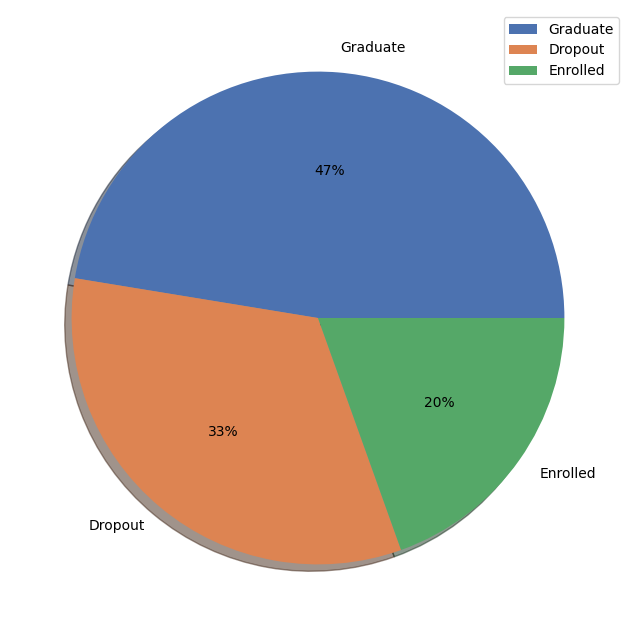

In [7]:
# Calculate class counts and labels
class_counts = df_train['Target'].value_counts()
class_labels = class_counts.index.tolist()

# Choose a different color palette (e.g., 'deep')
colors = sns.color_palette('deep', n_colors=len(class_labels))

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(x=class_counts.values, labels=class_labels, colors=colors,
        autopct='%.0f%%', shadow=True)

# Add legend
plt.legend(class_labels, loc="best")
plt.show()

**Let's look at each variable individually to understand the distribution of data in each column.**



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


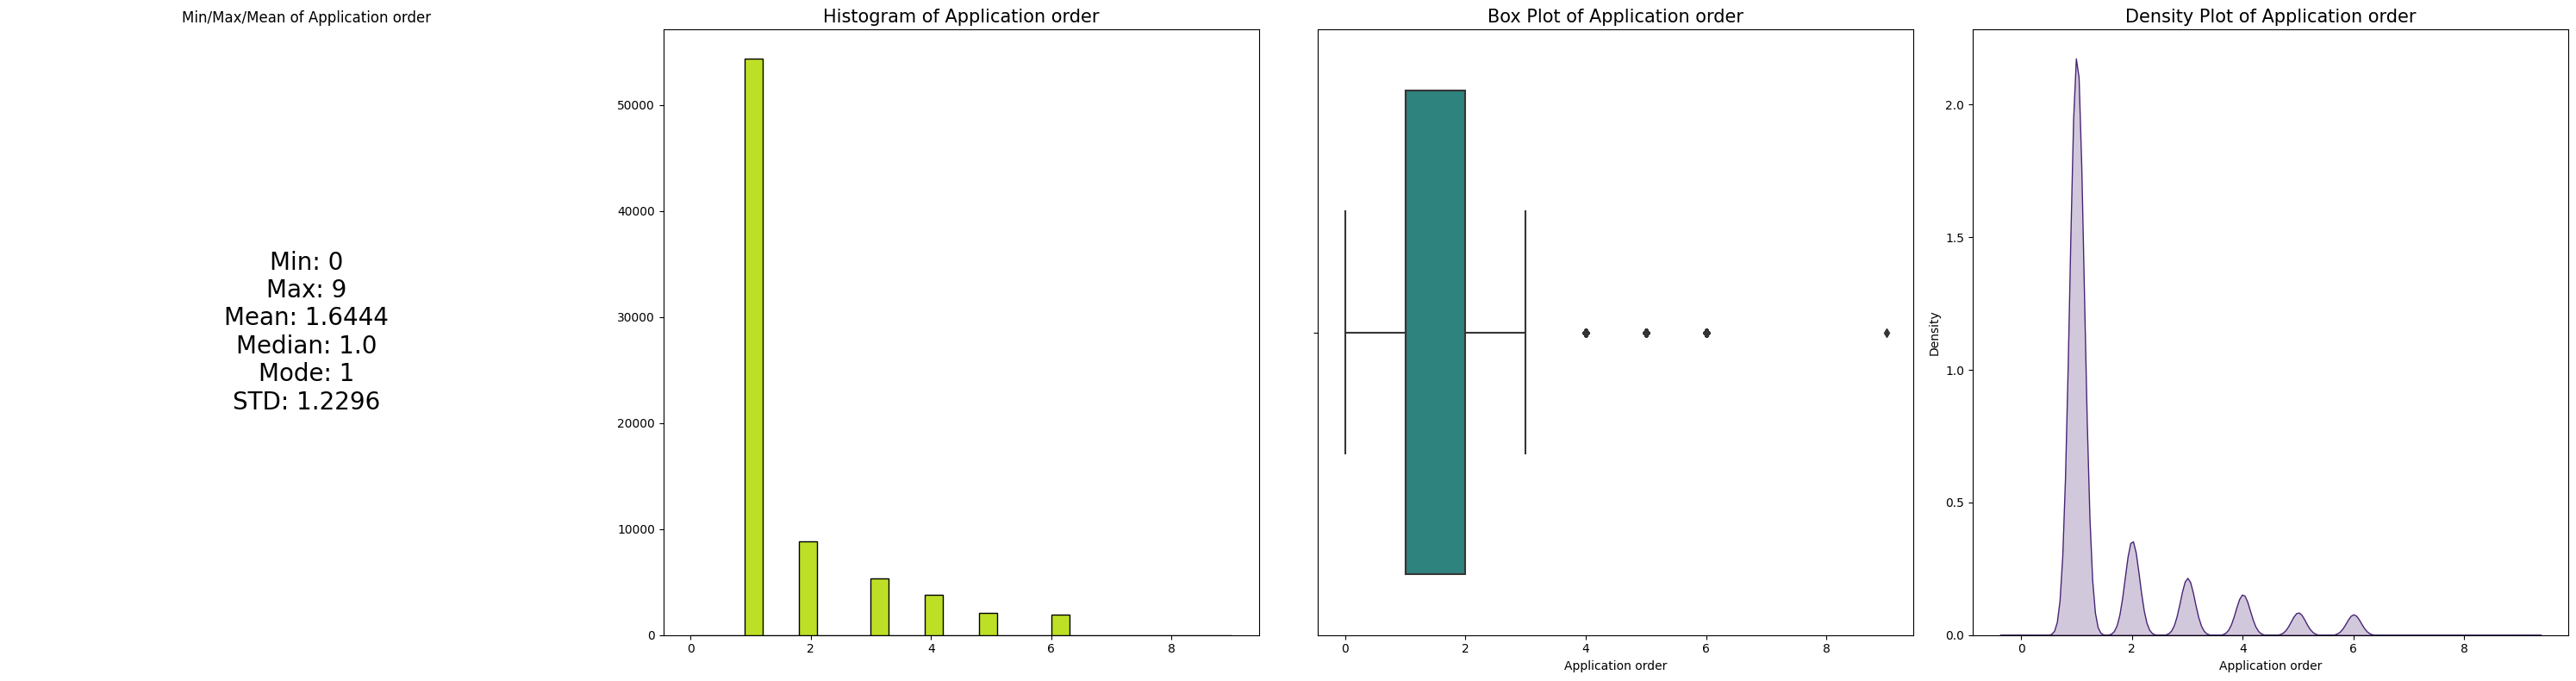

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


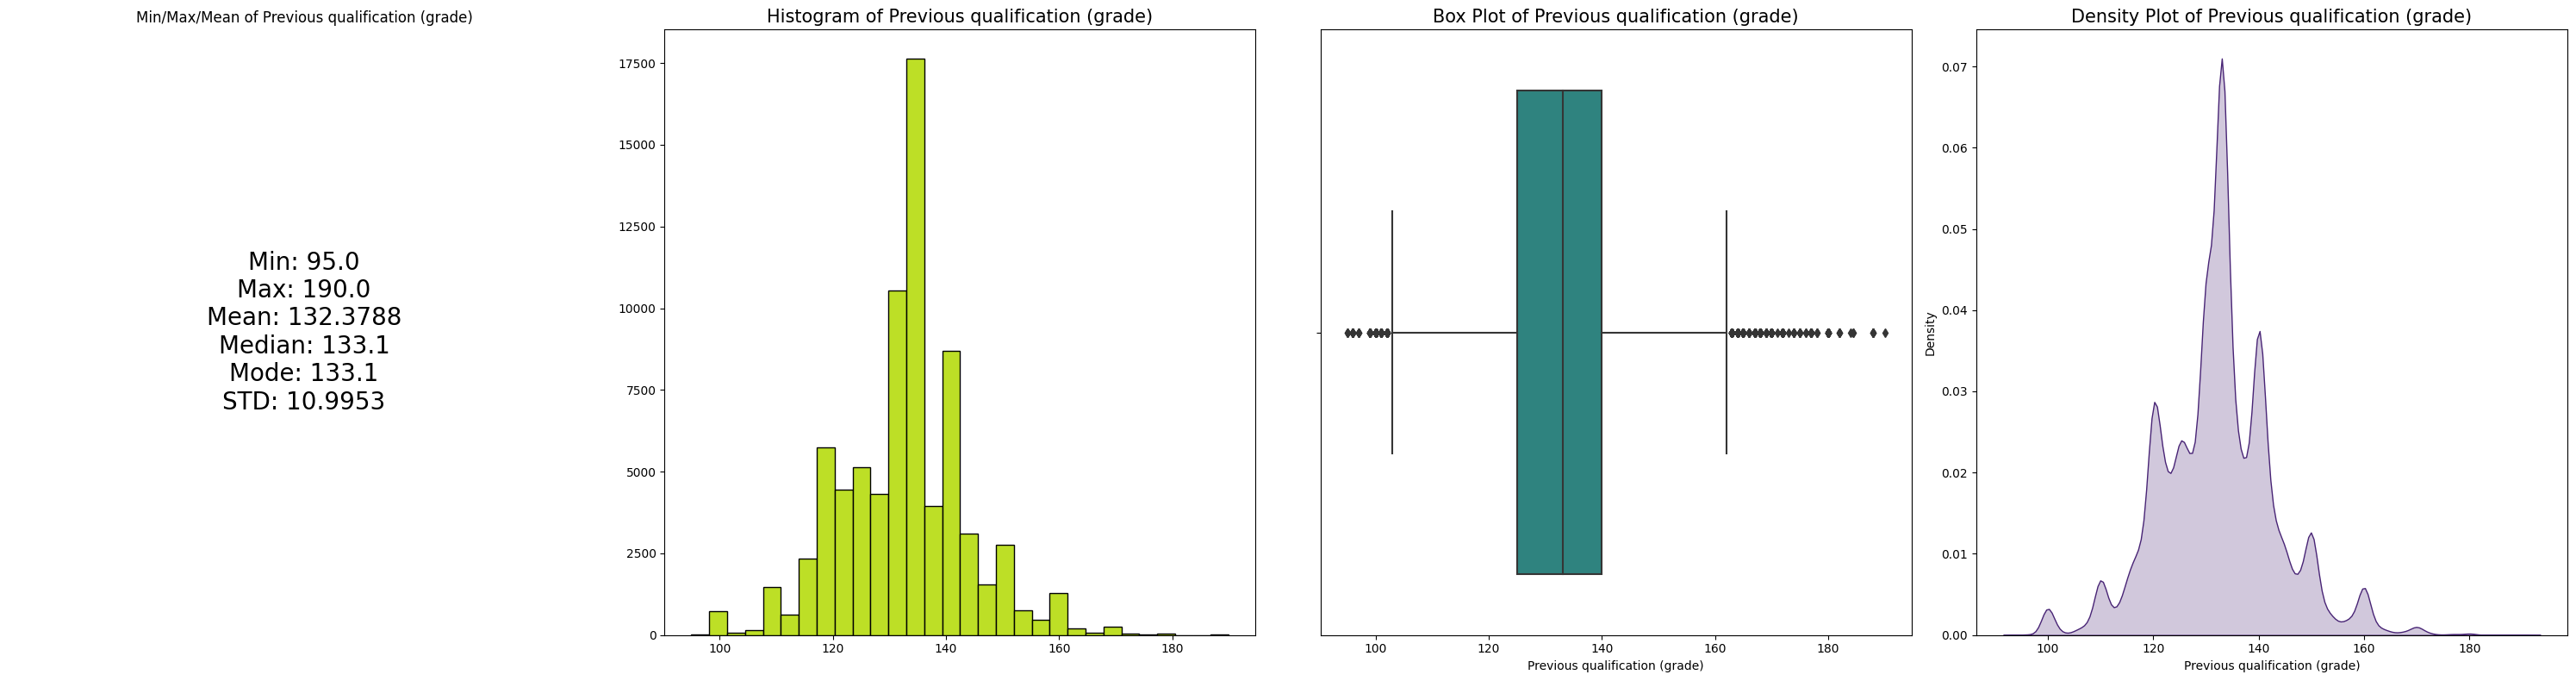

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


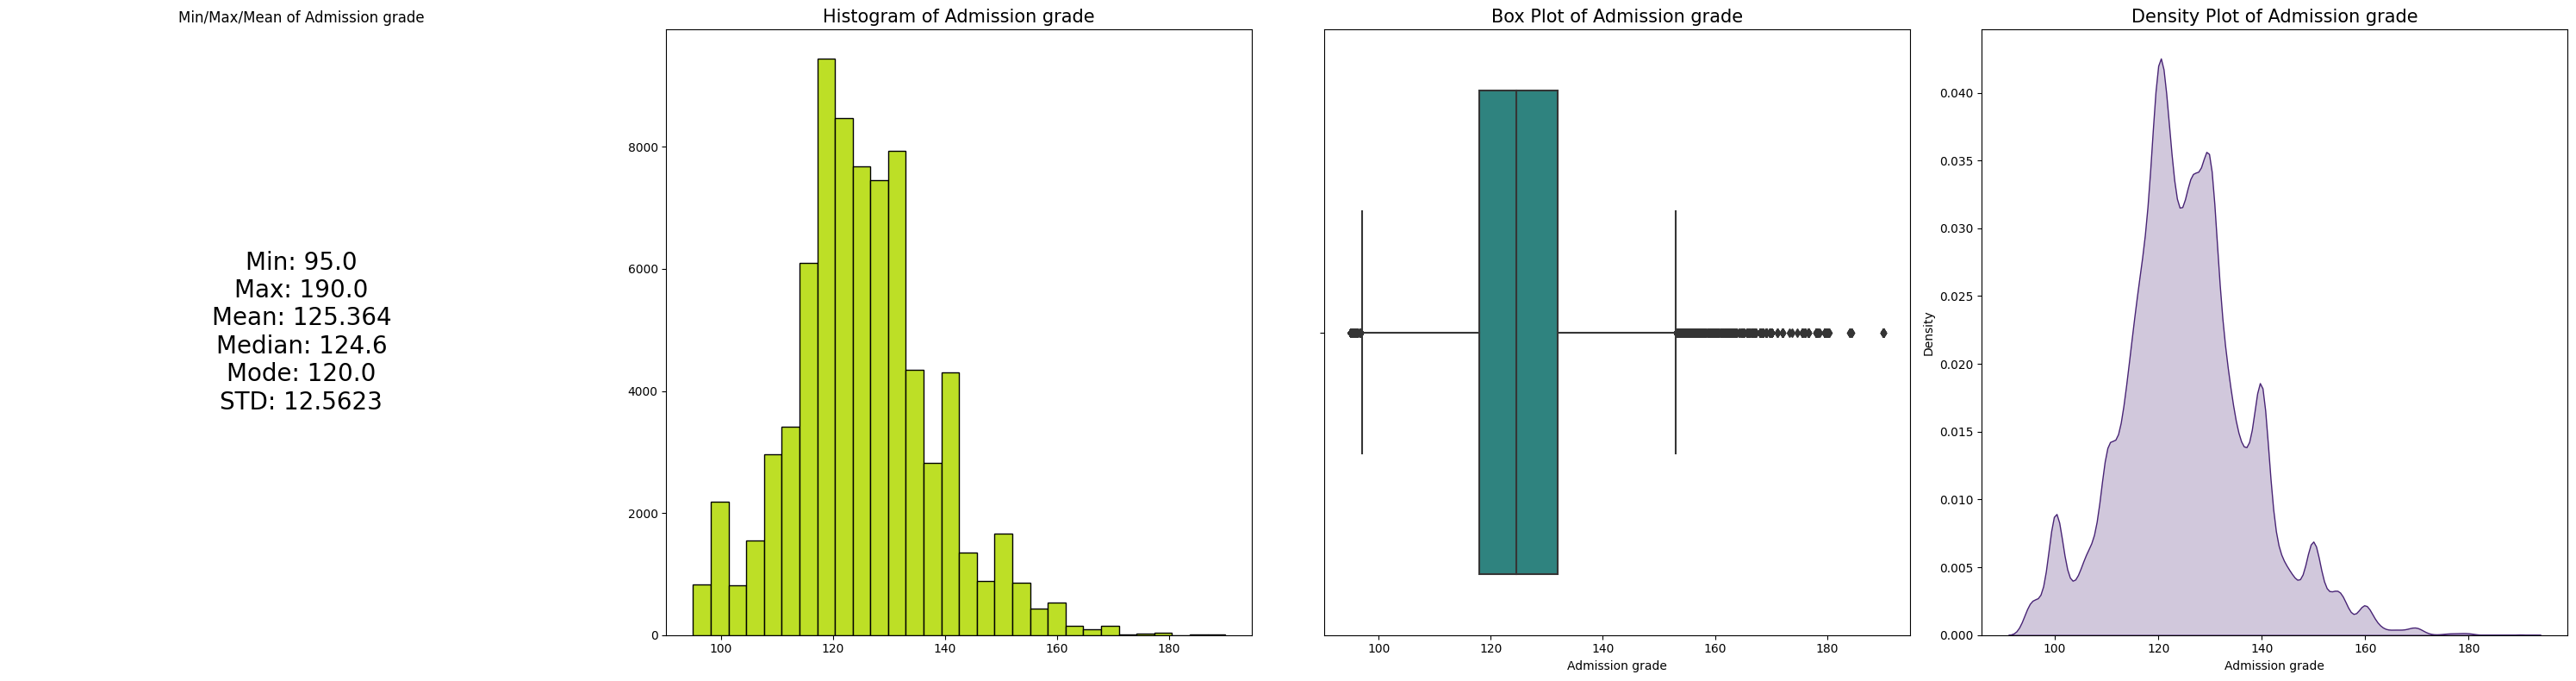

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


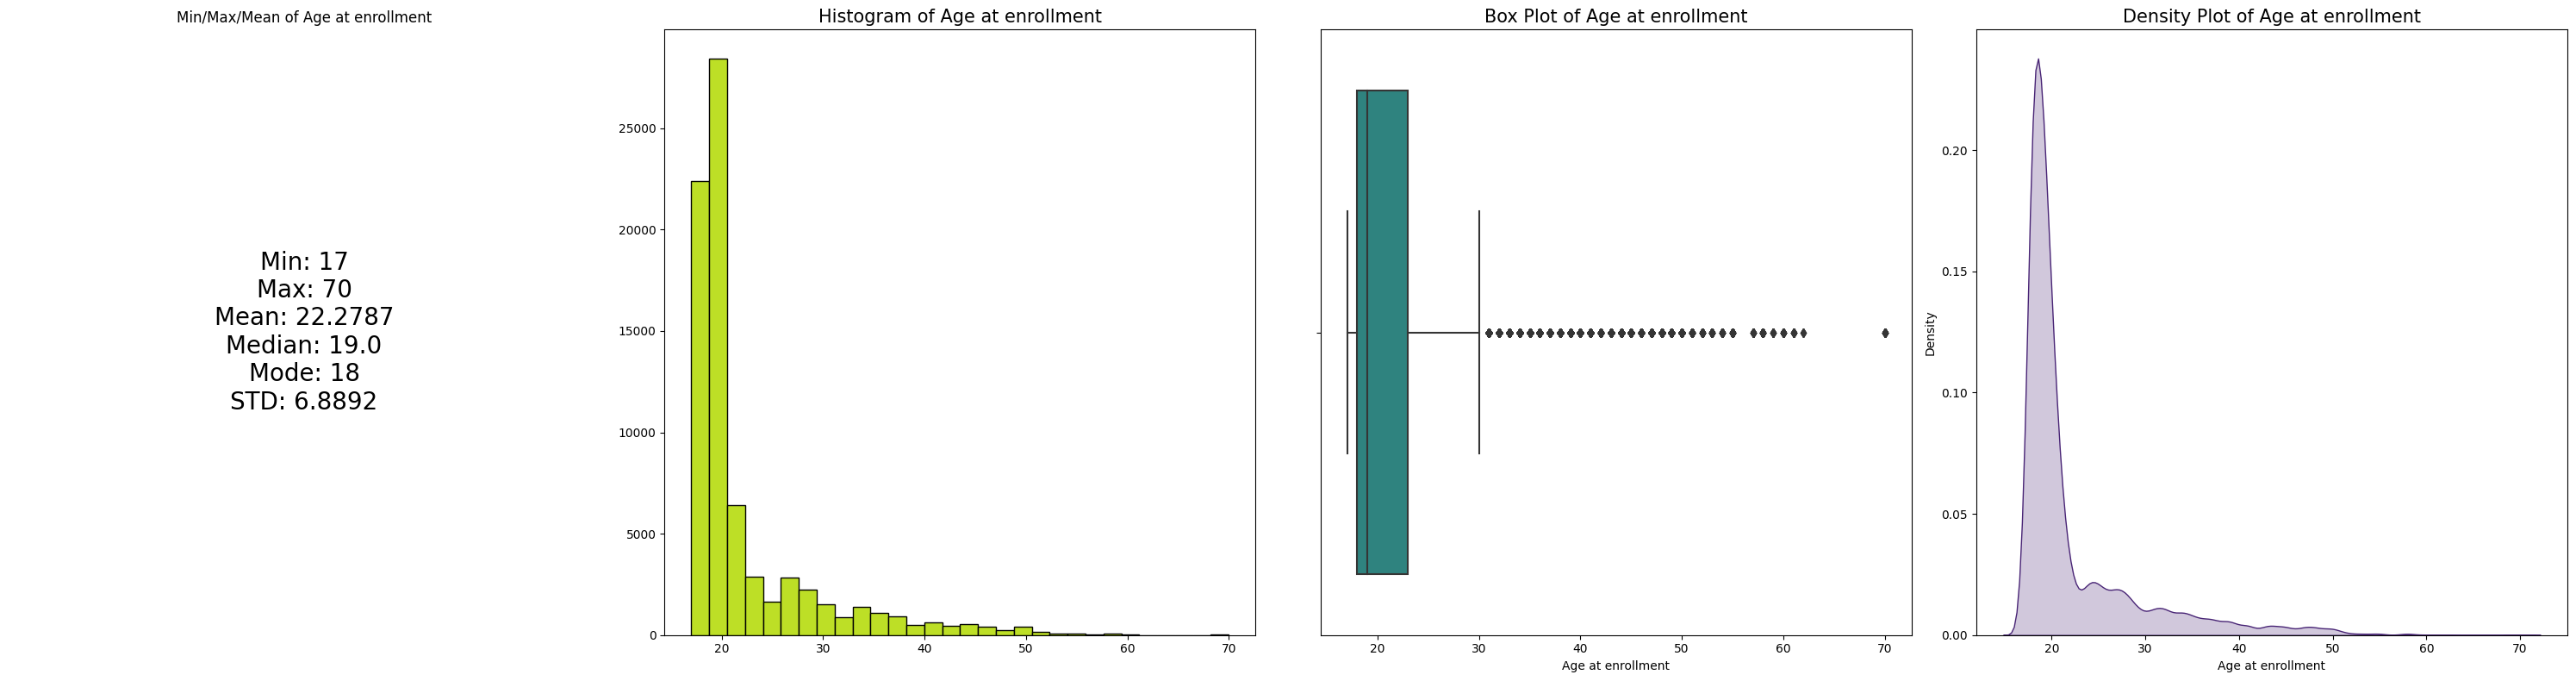

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


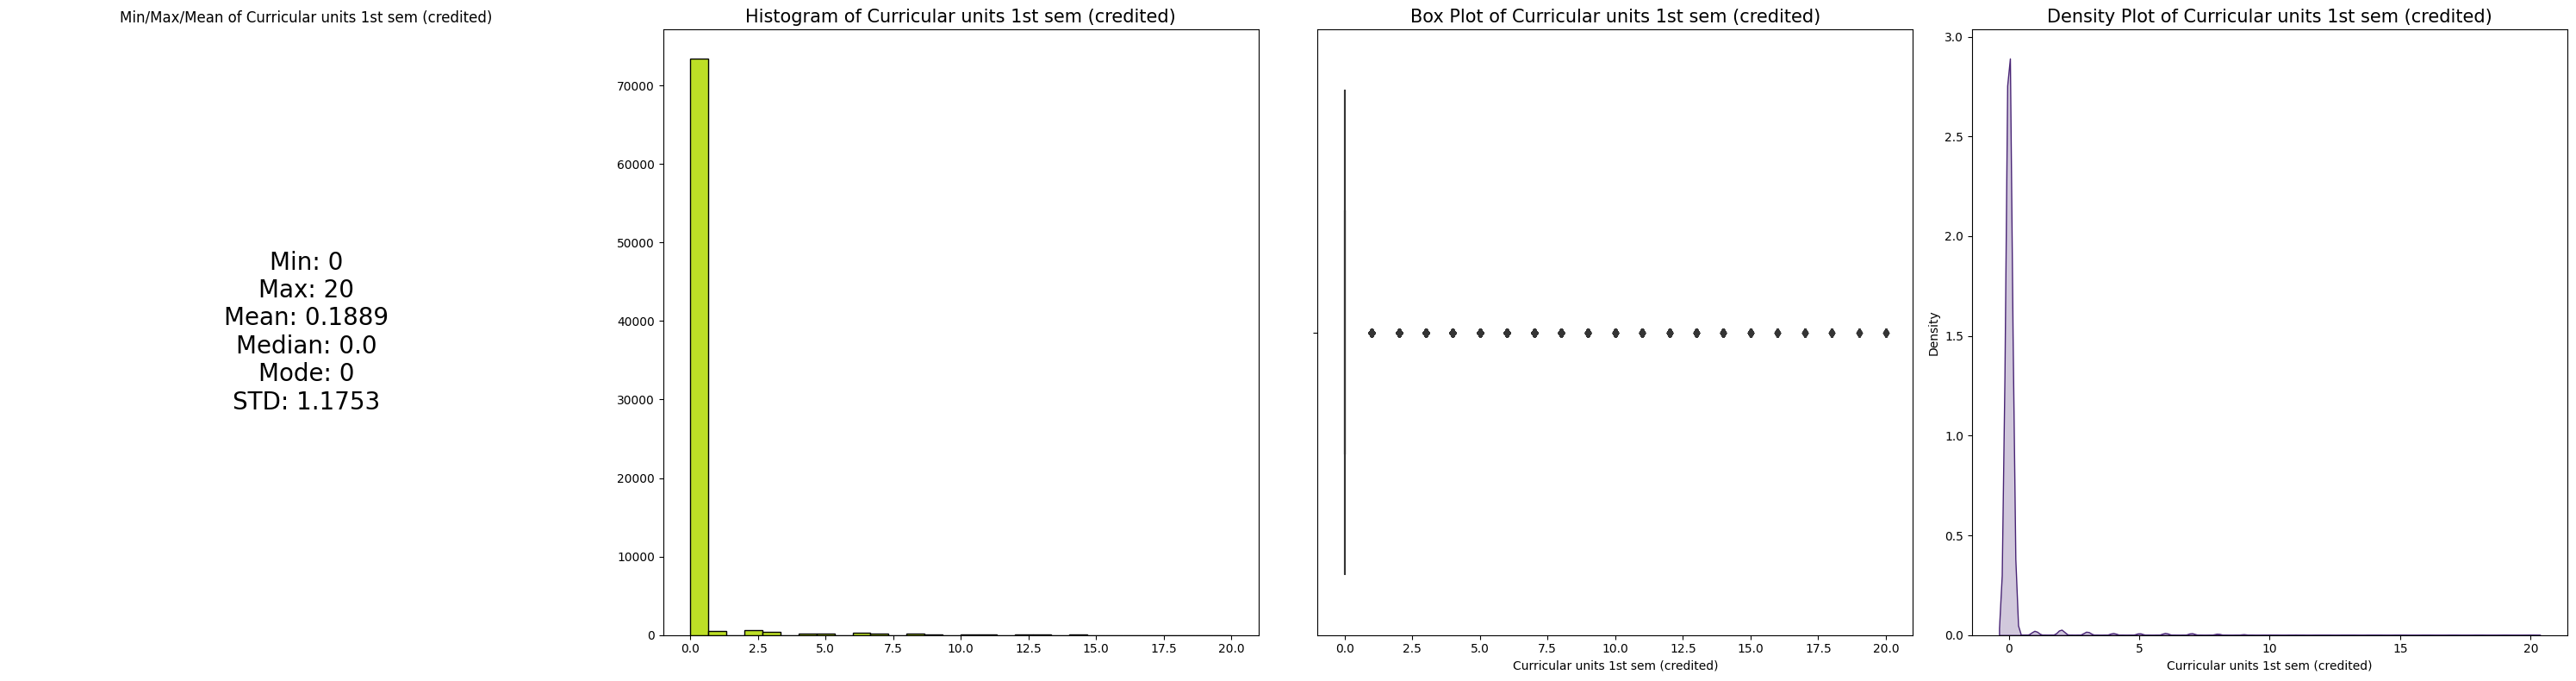

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


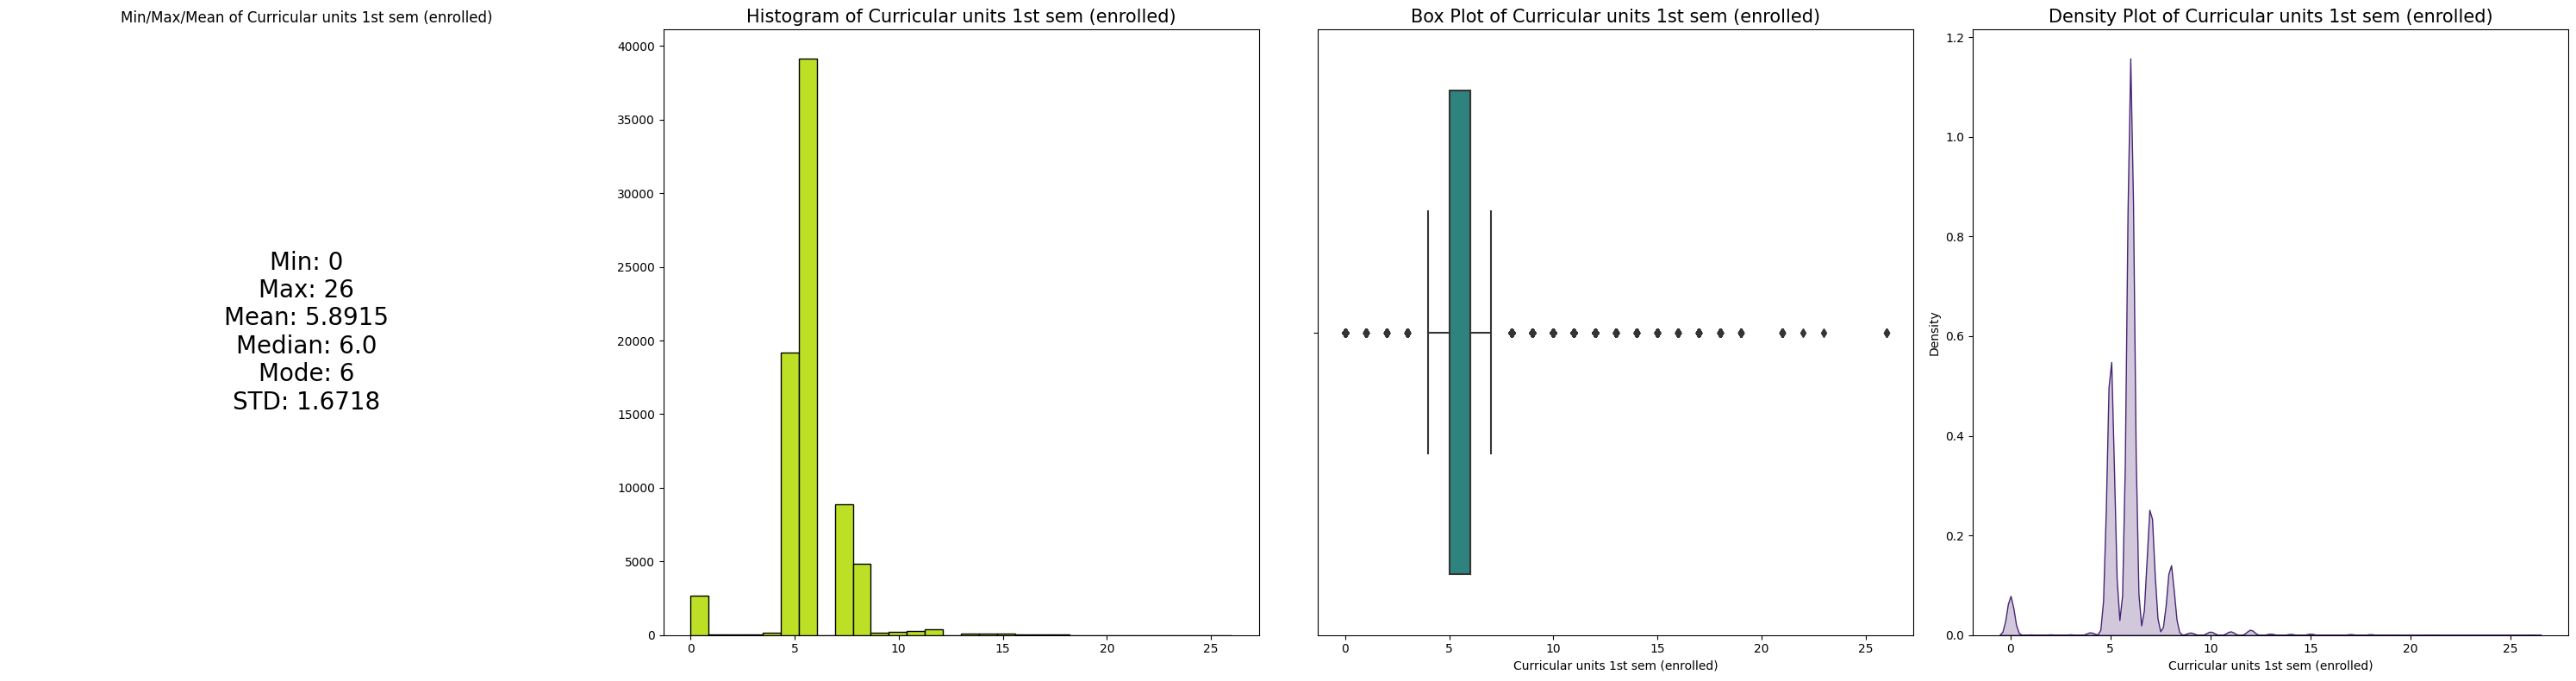

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


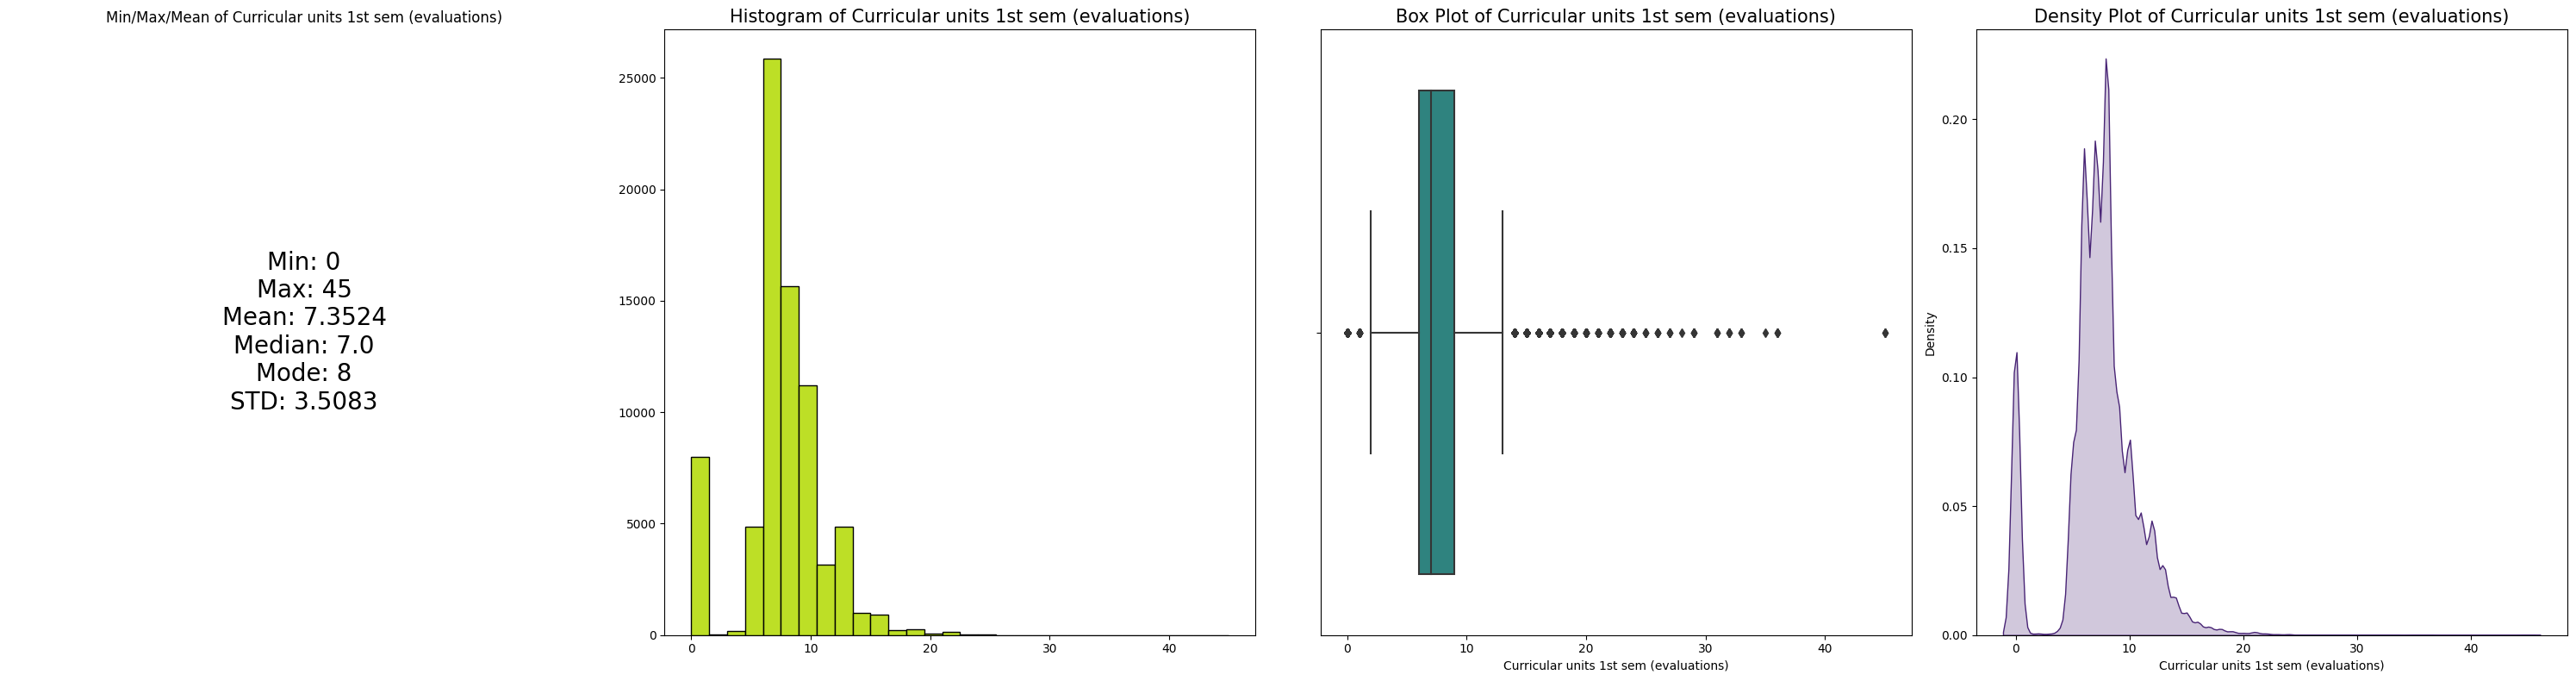

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


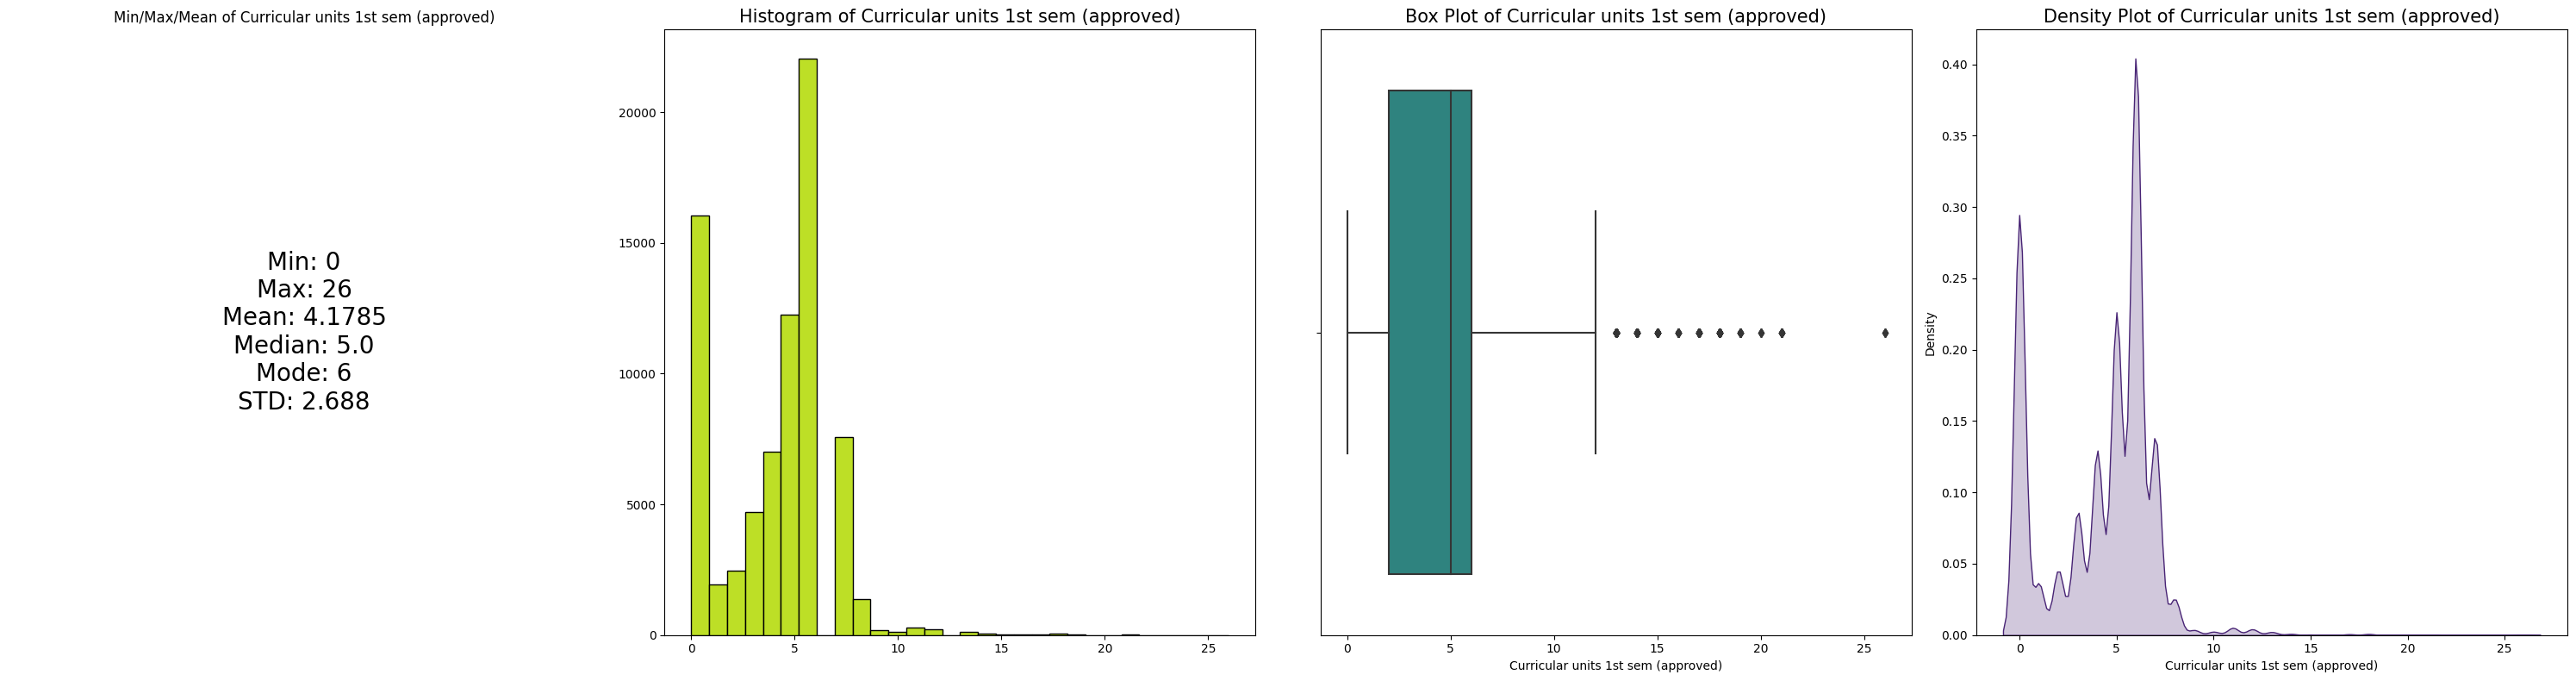

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


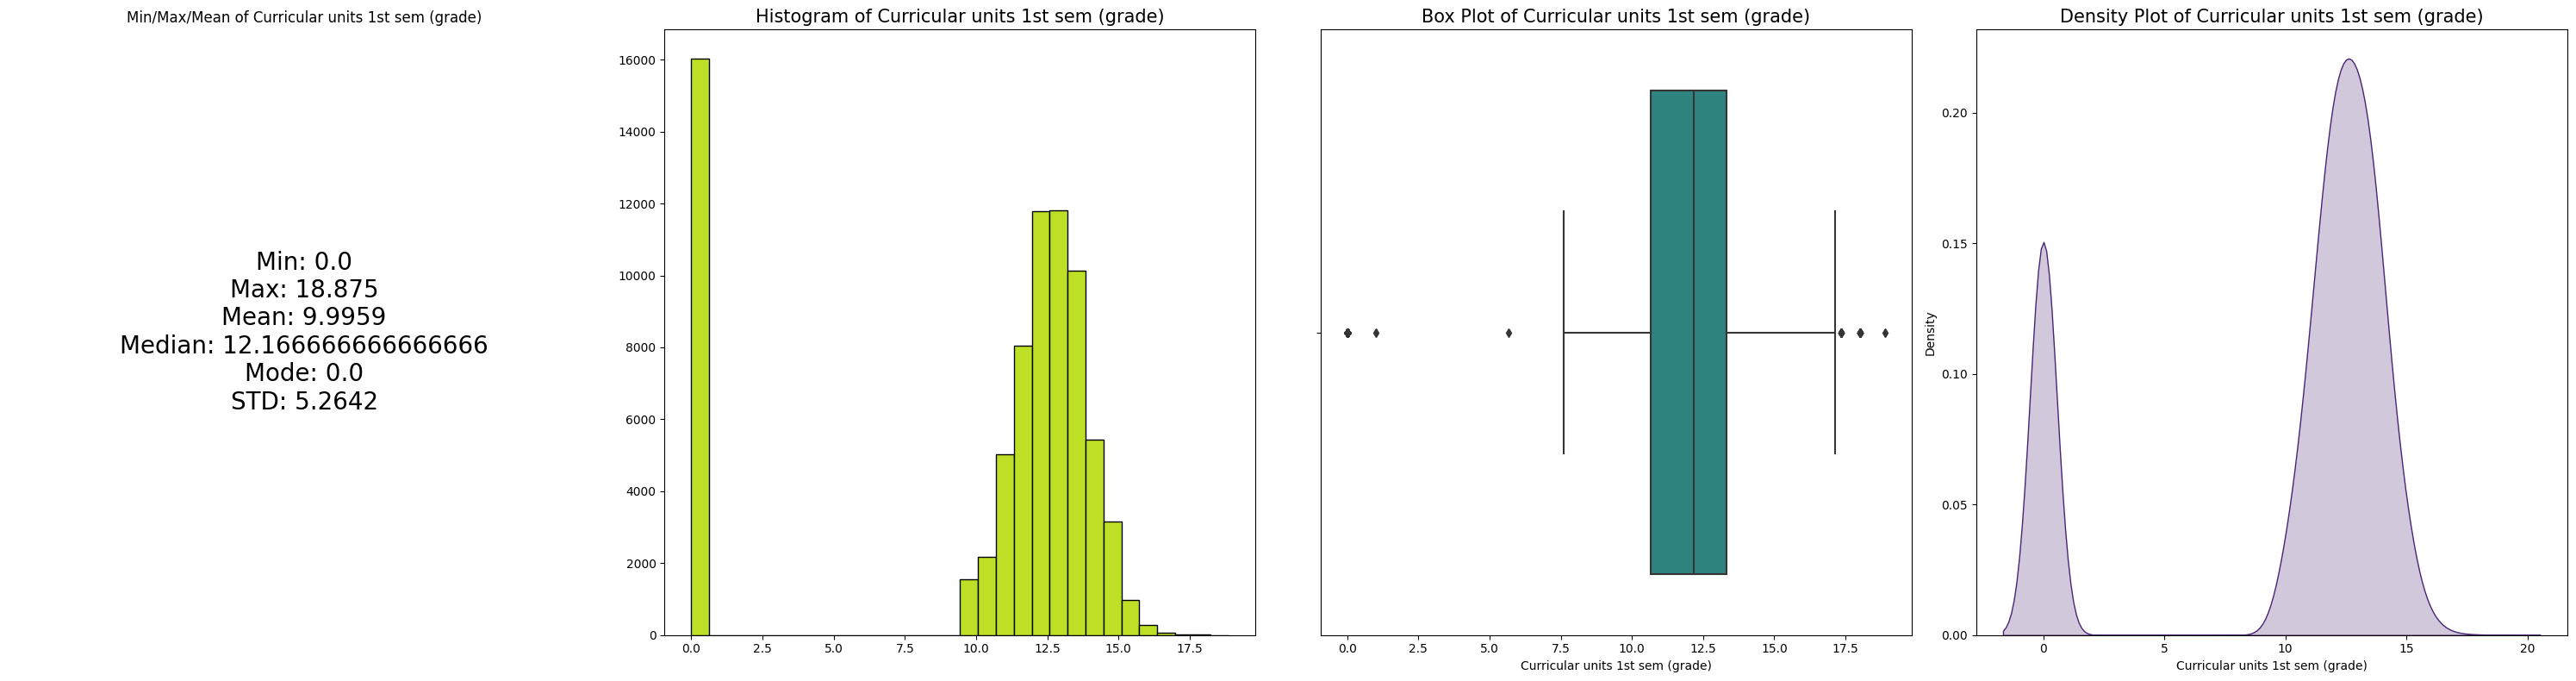

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


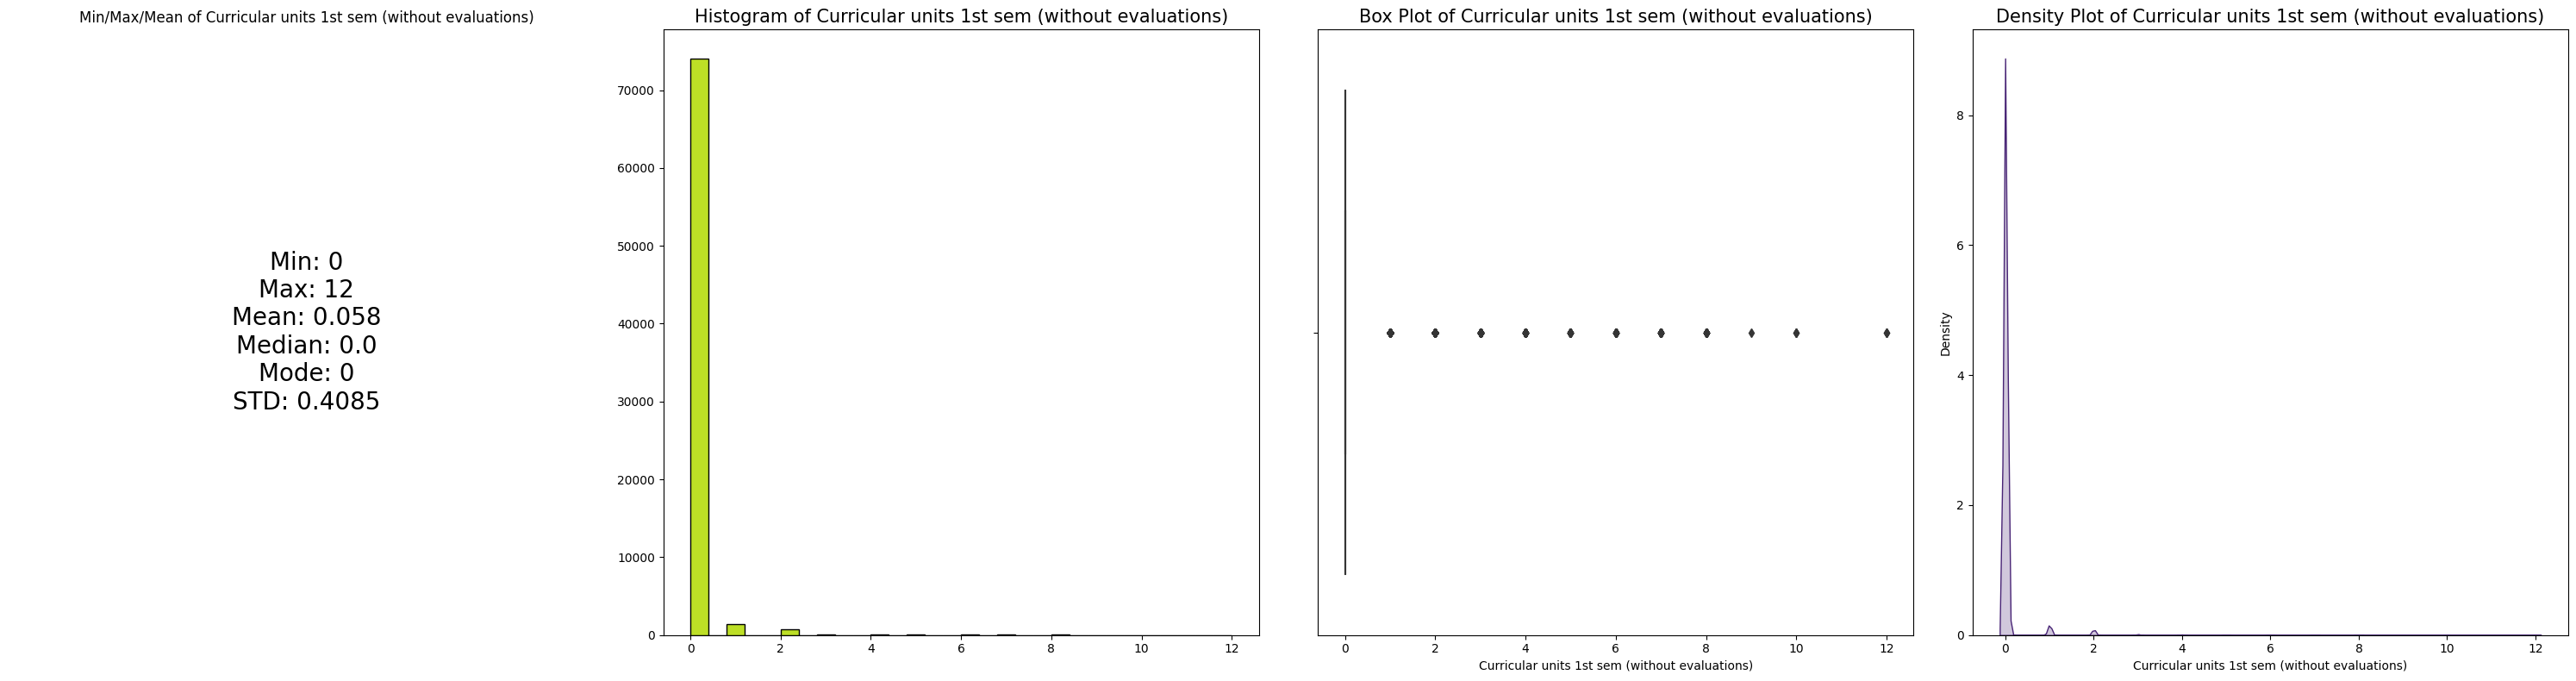

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


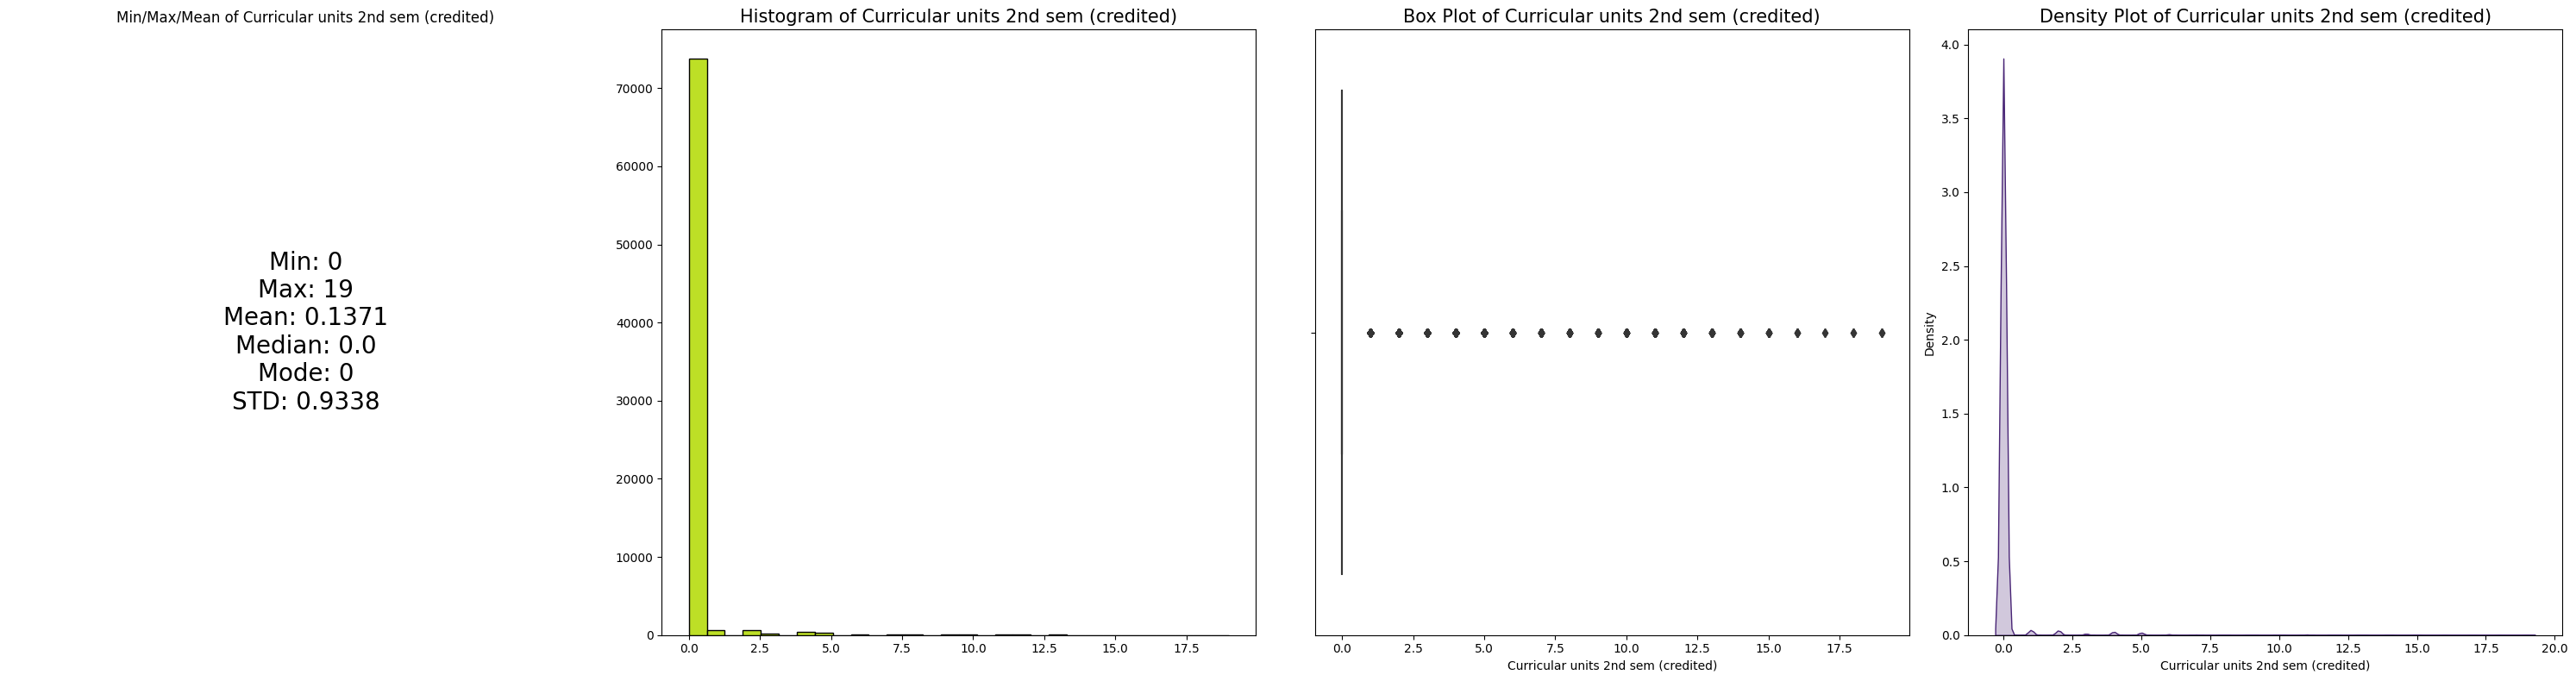

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


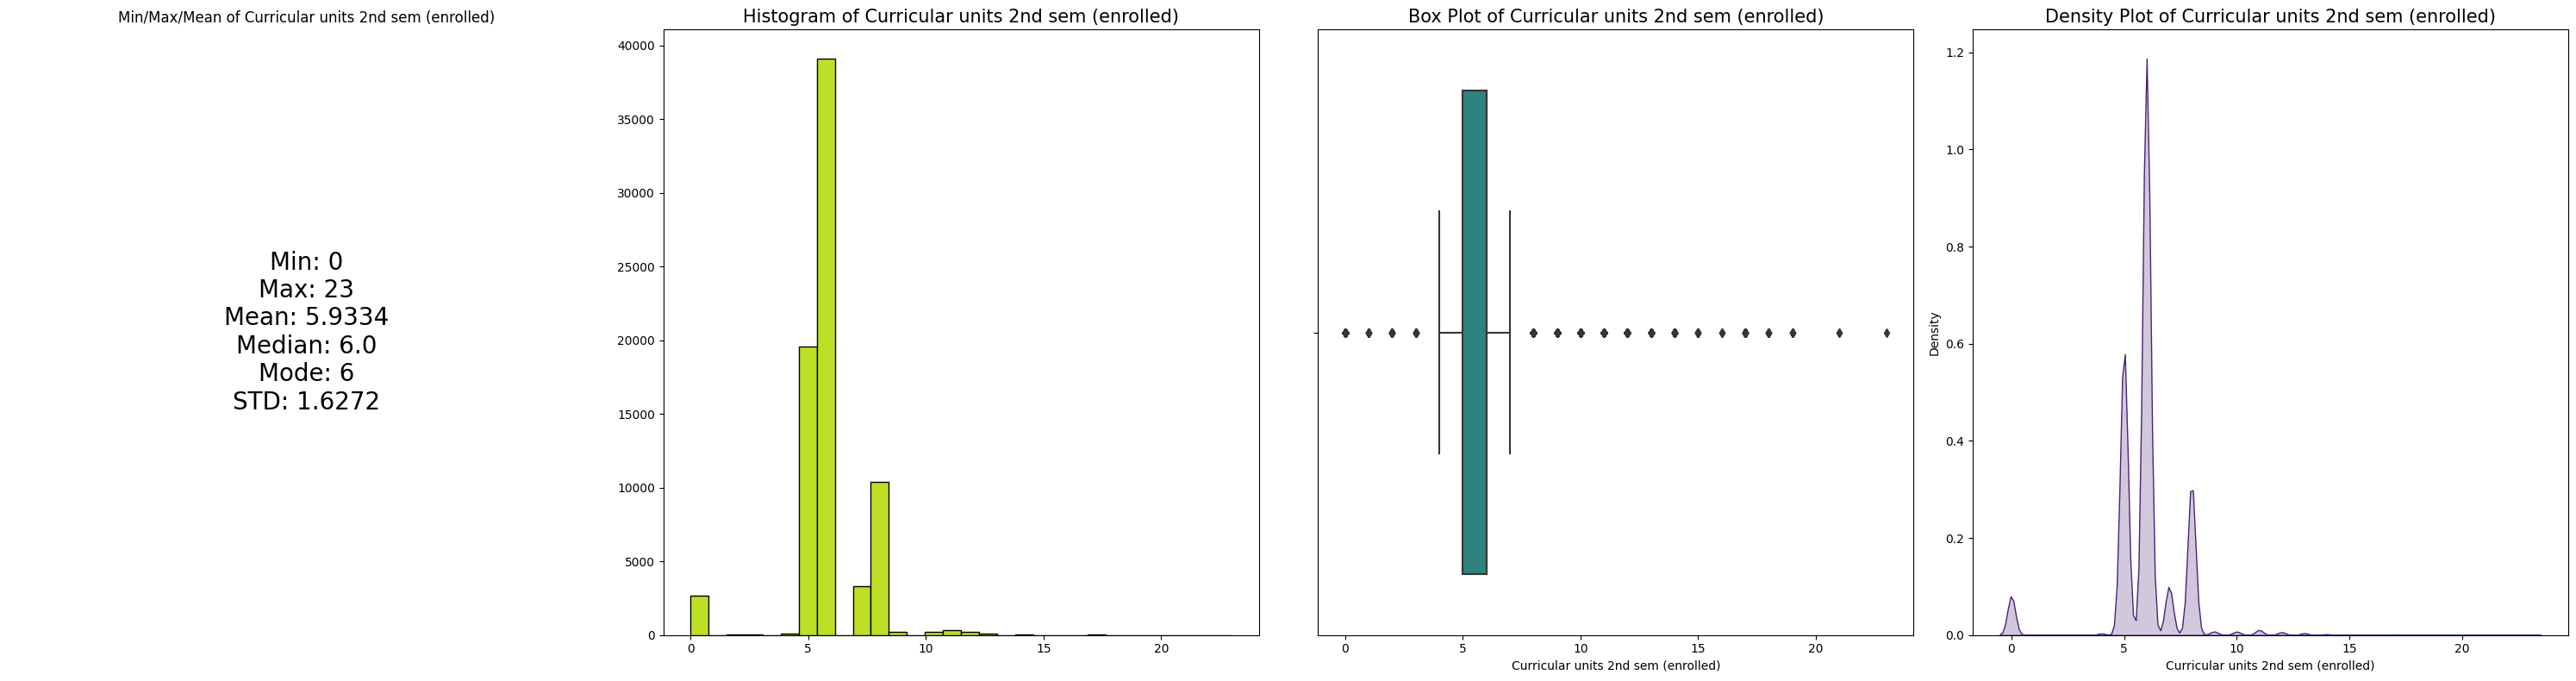

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


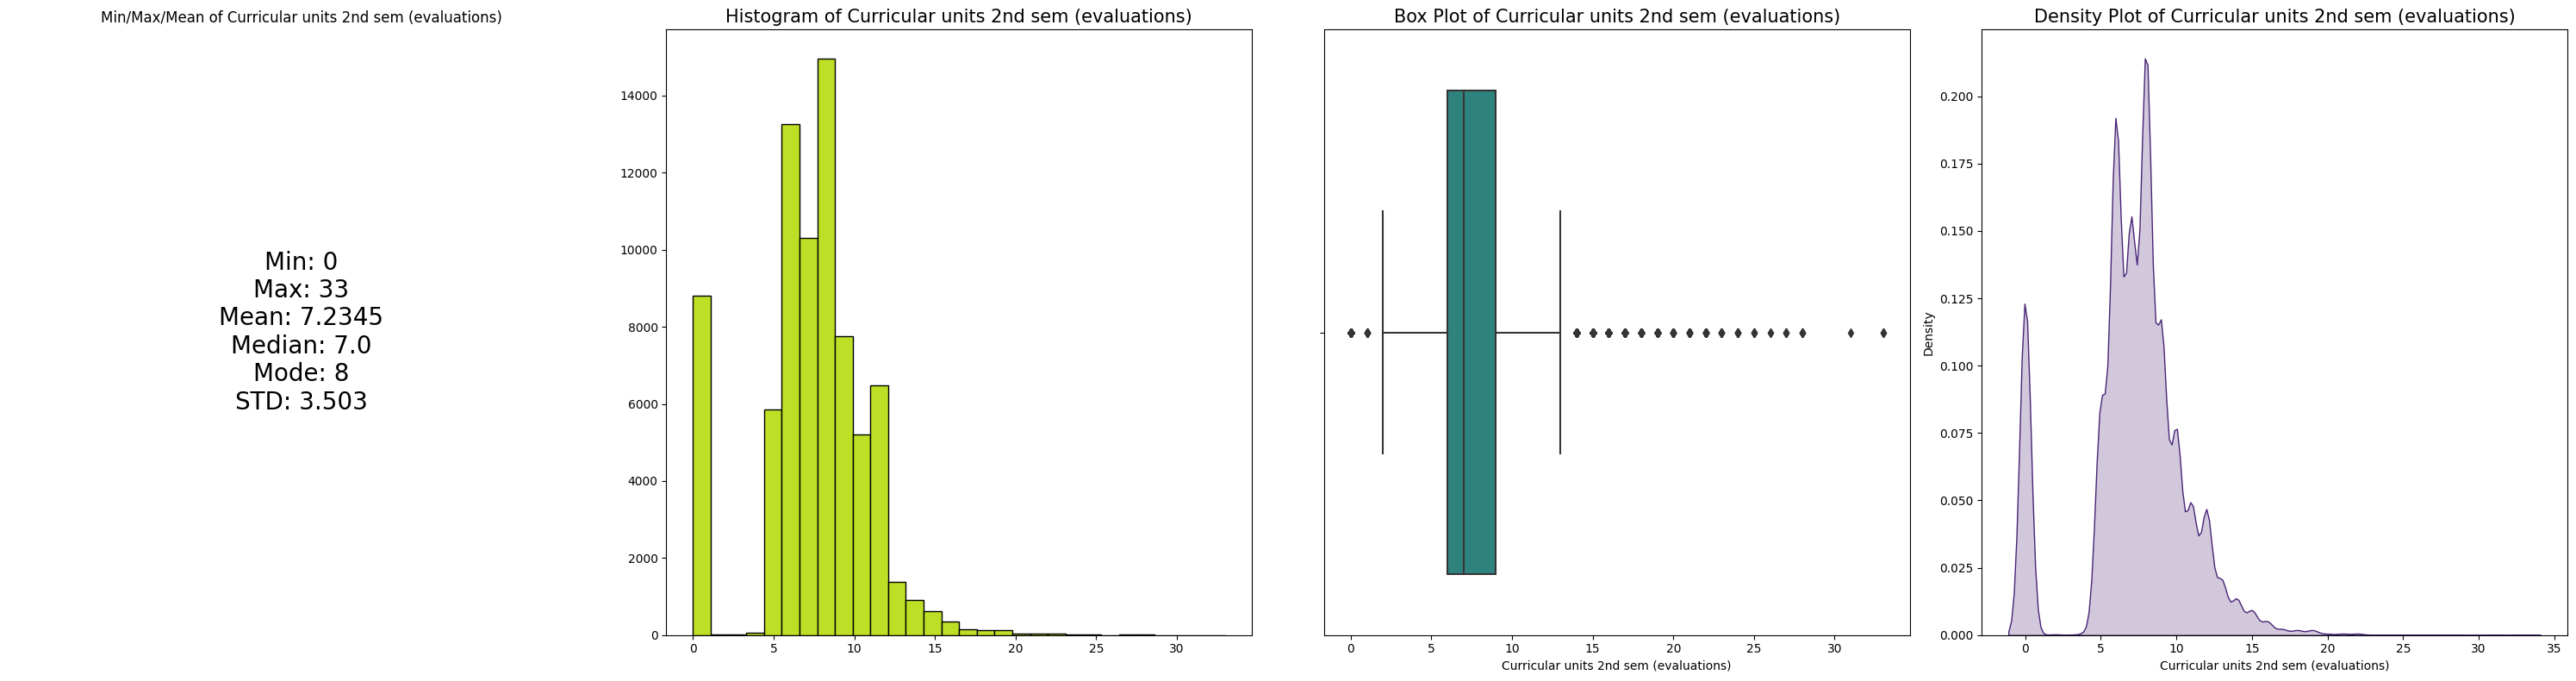

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


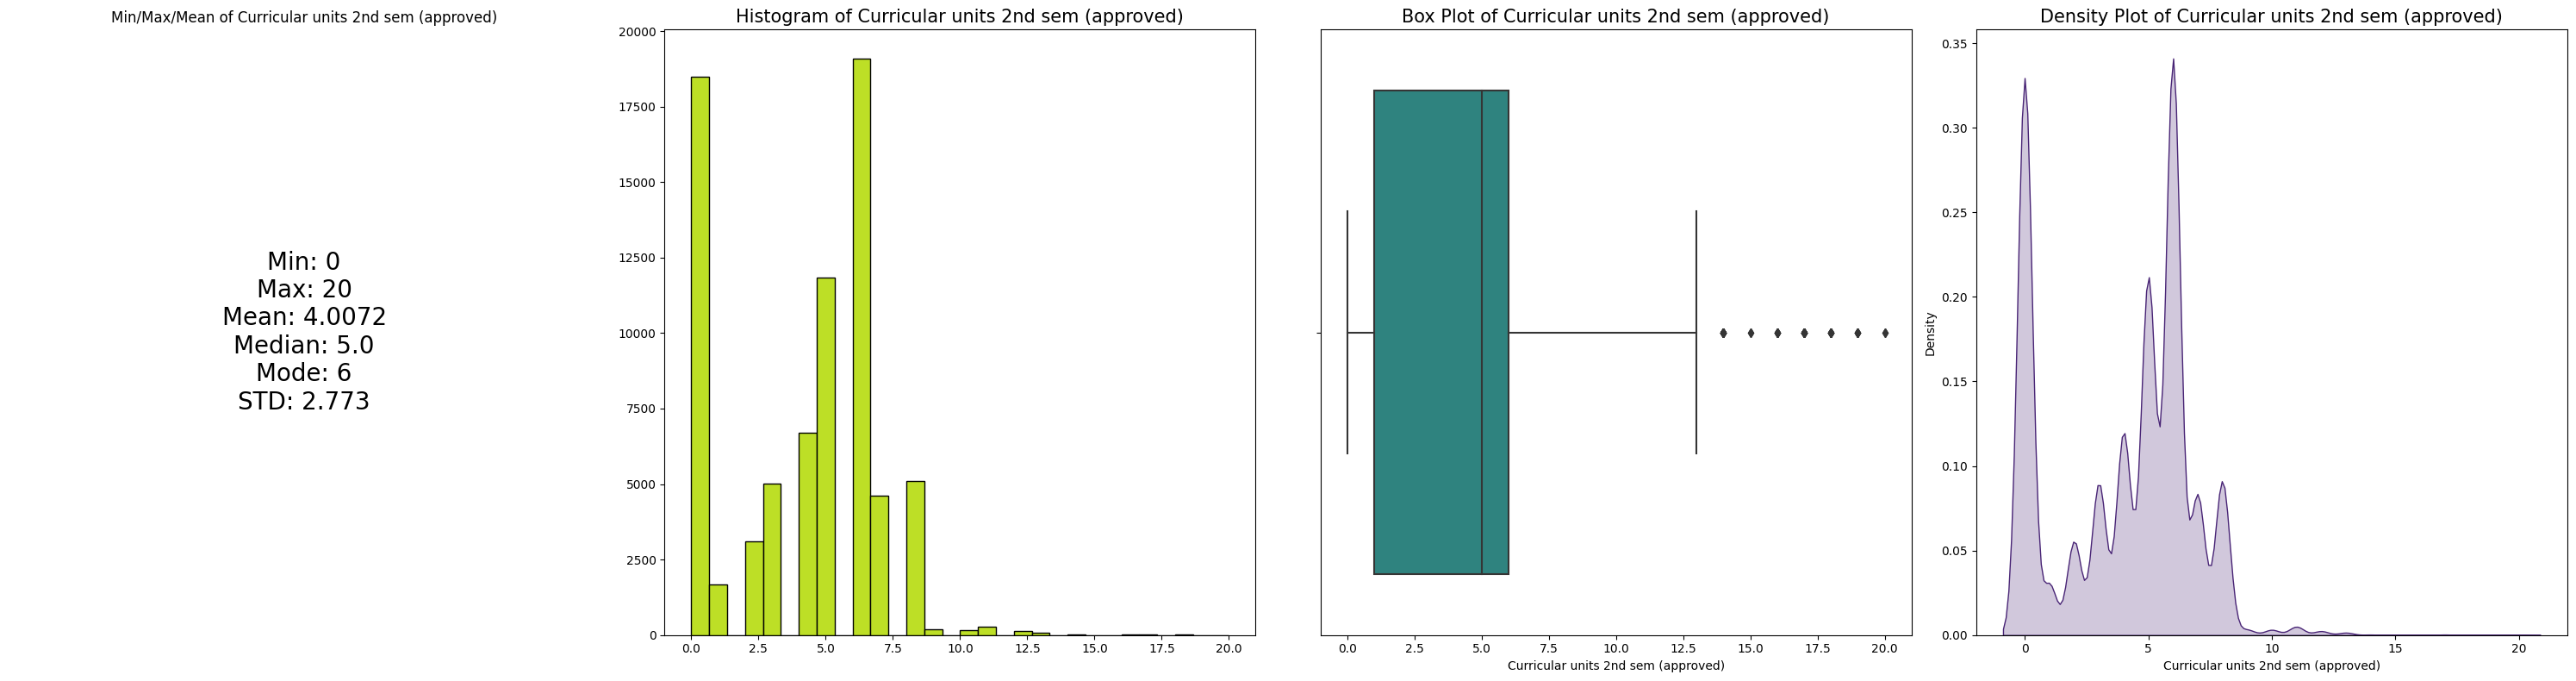

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


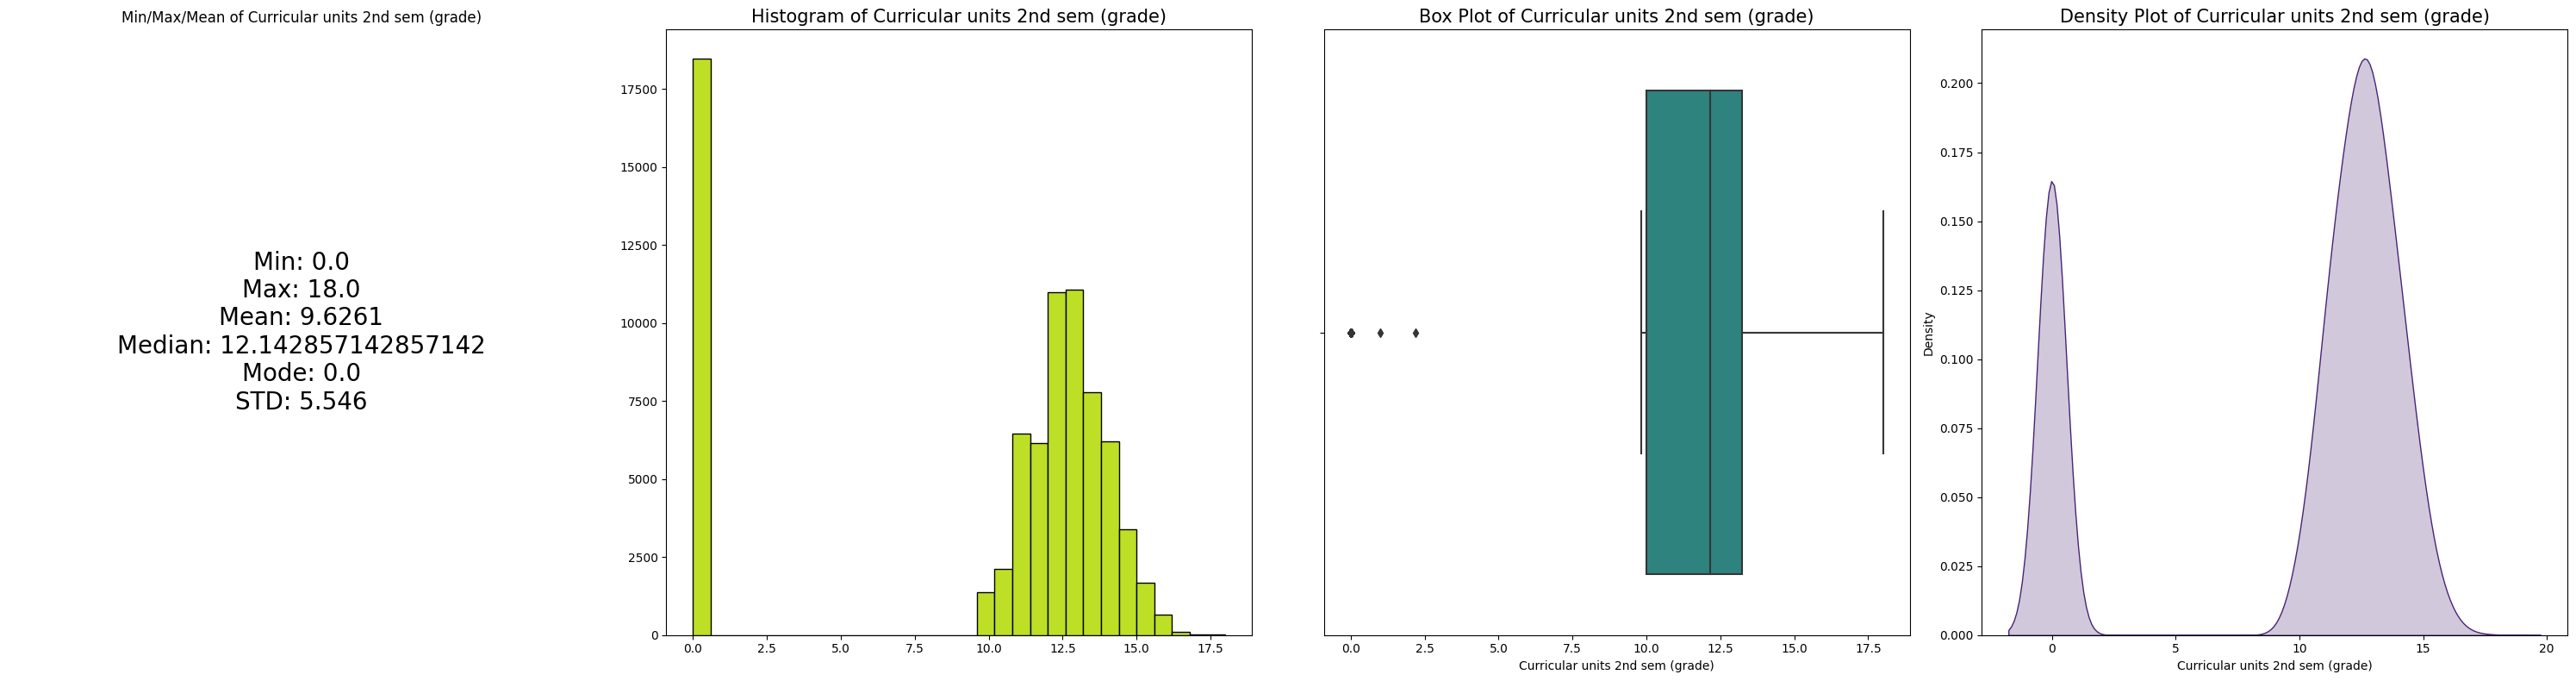

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


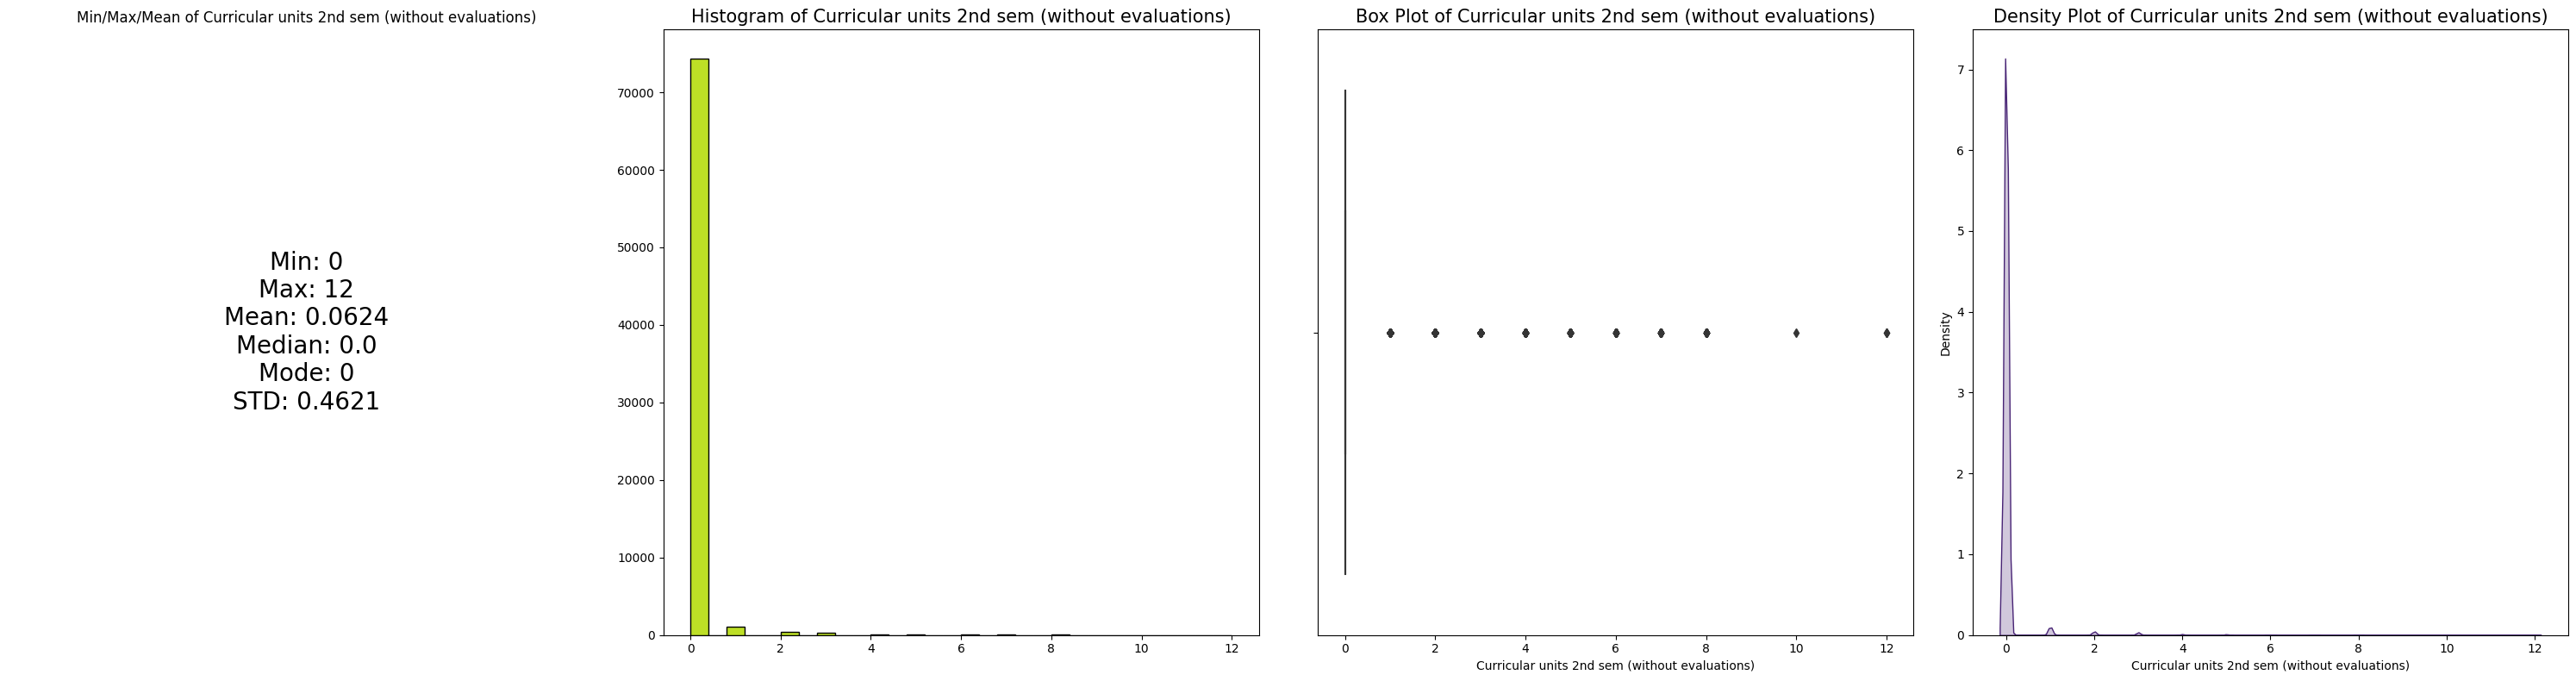

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


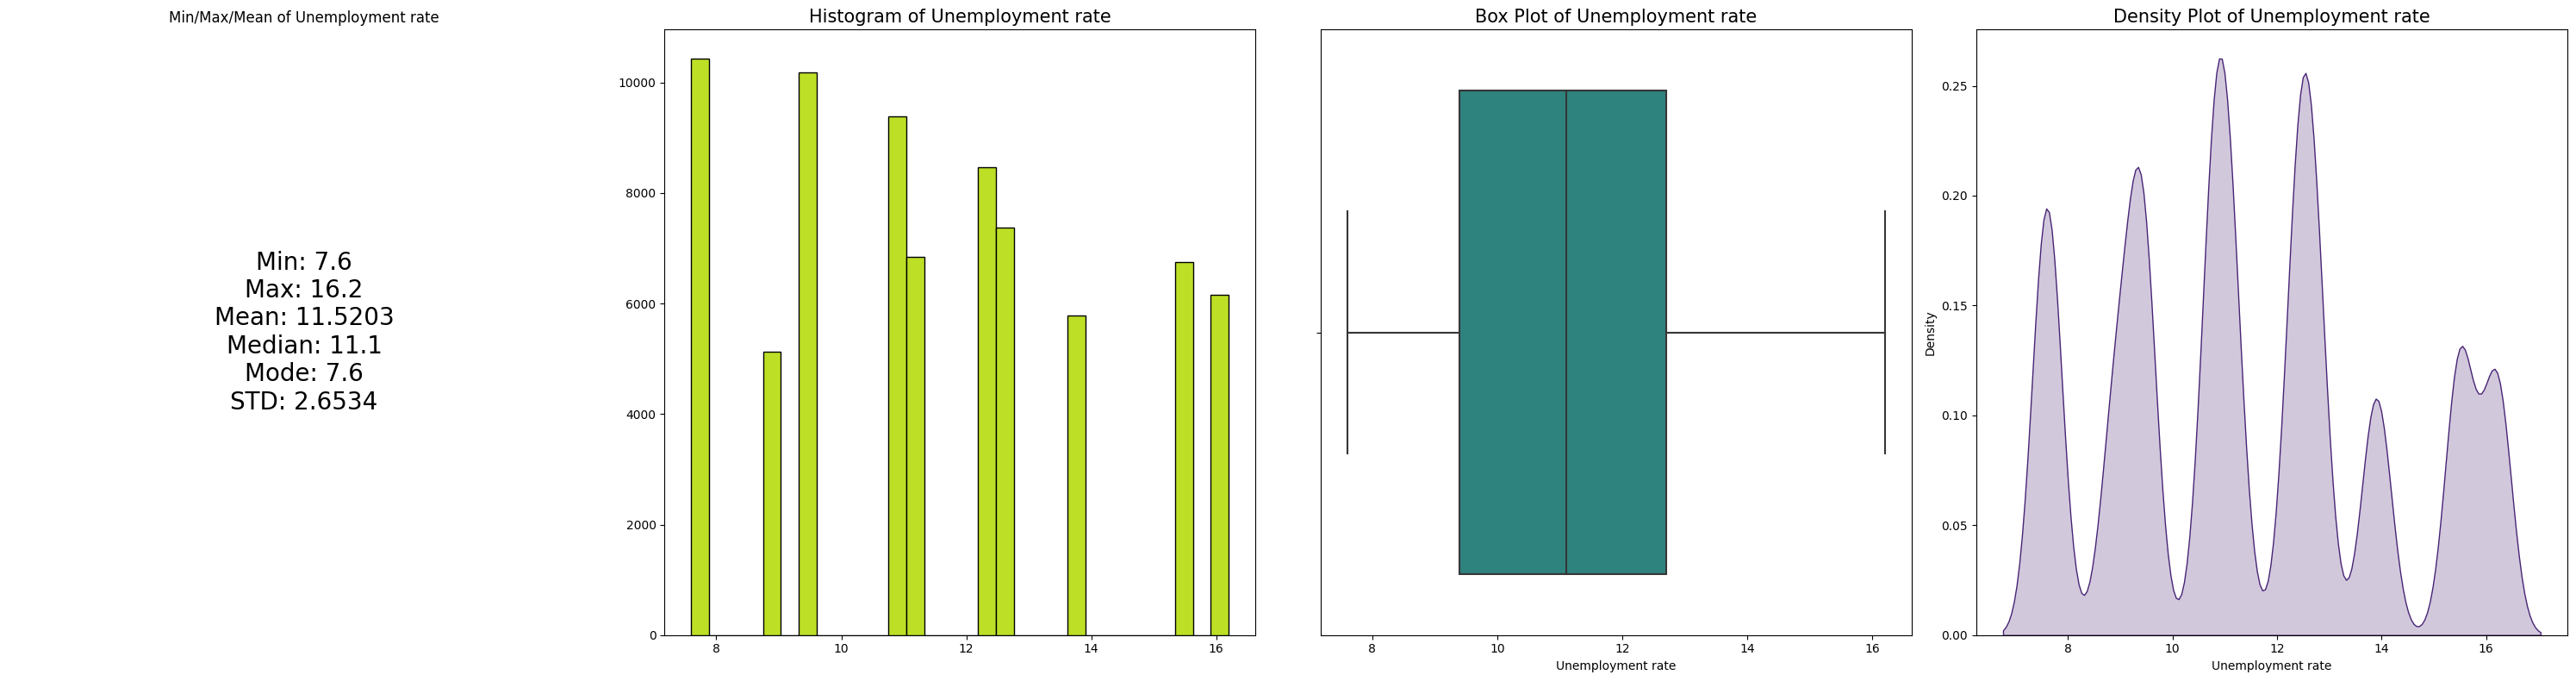

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


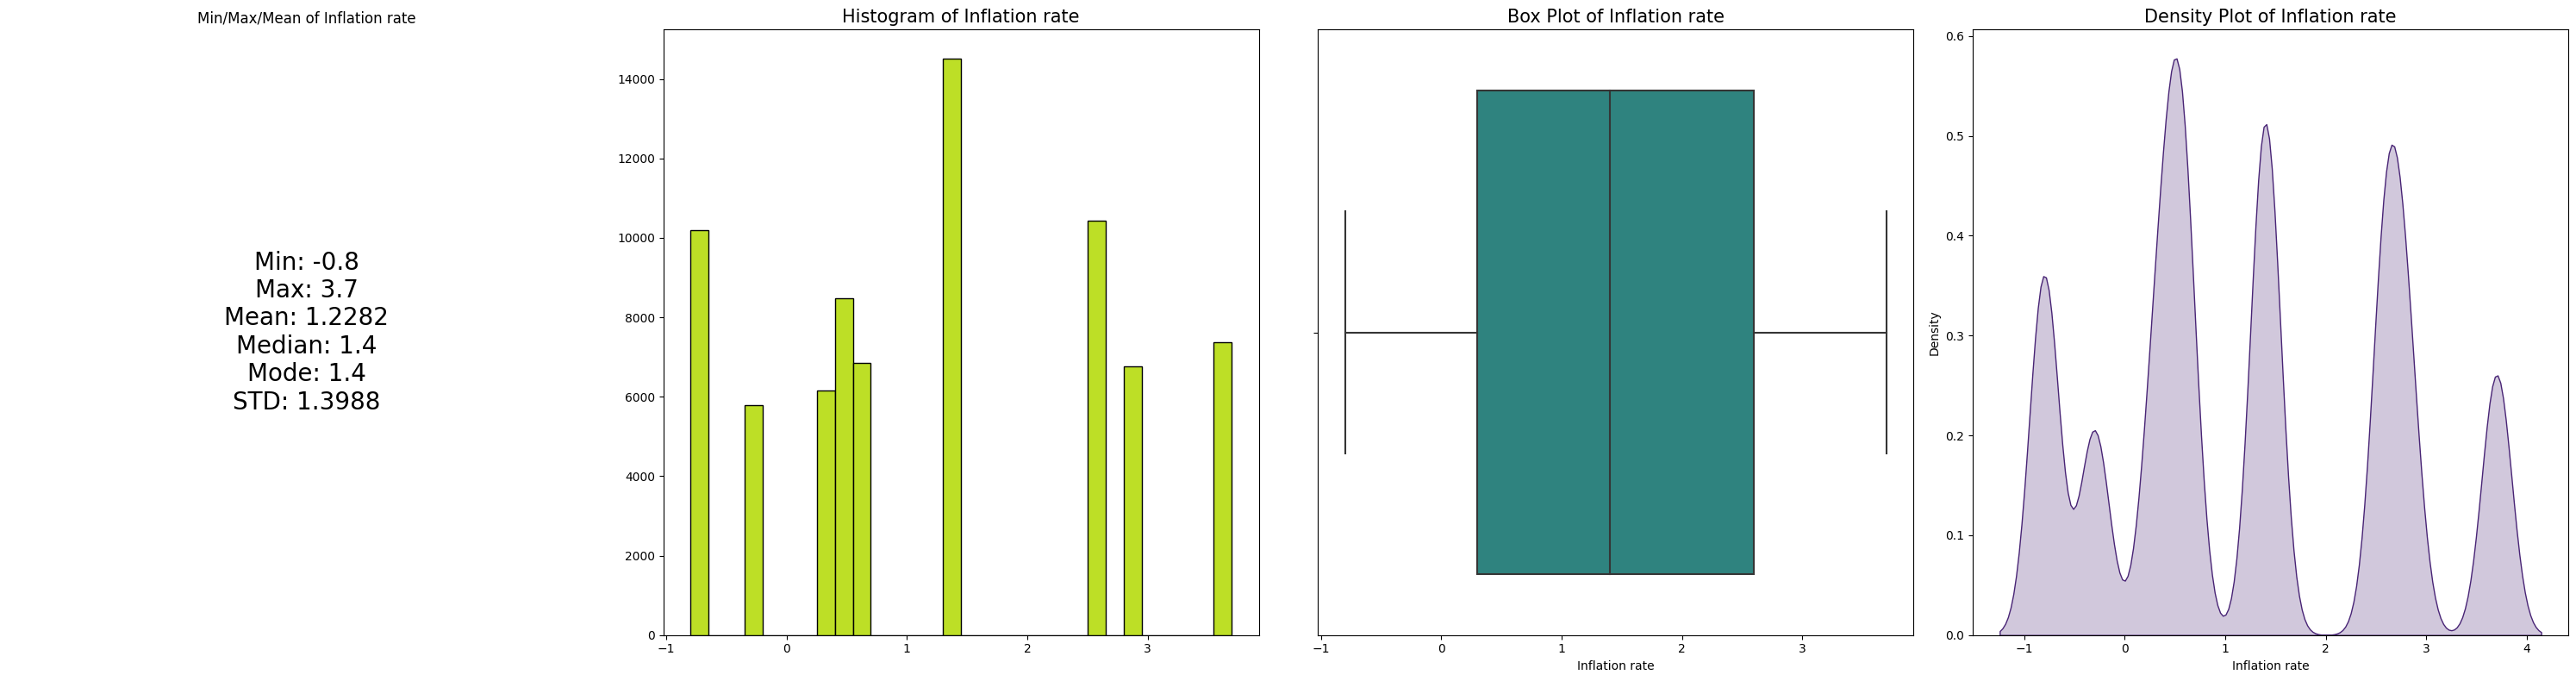

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


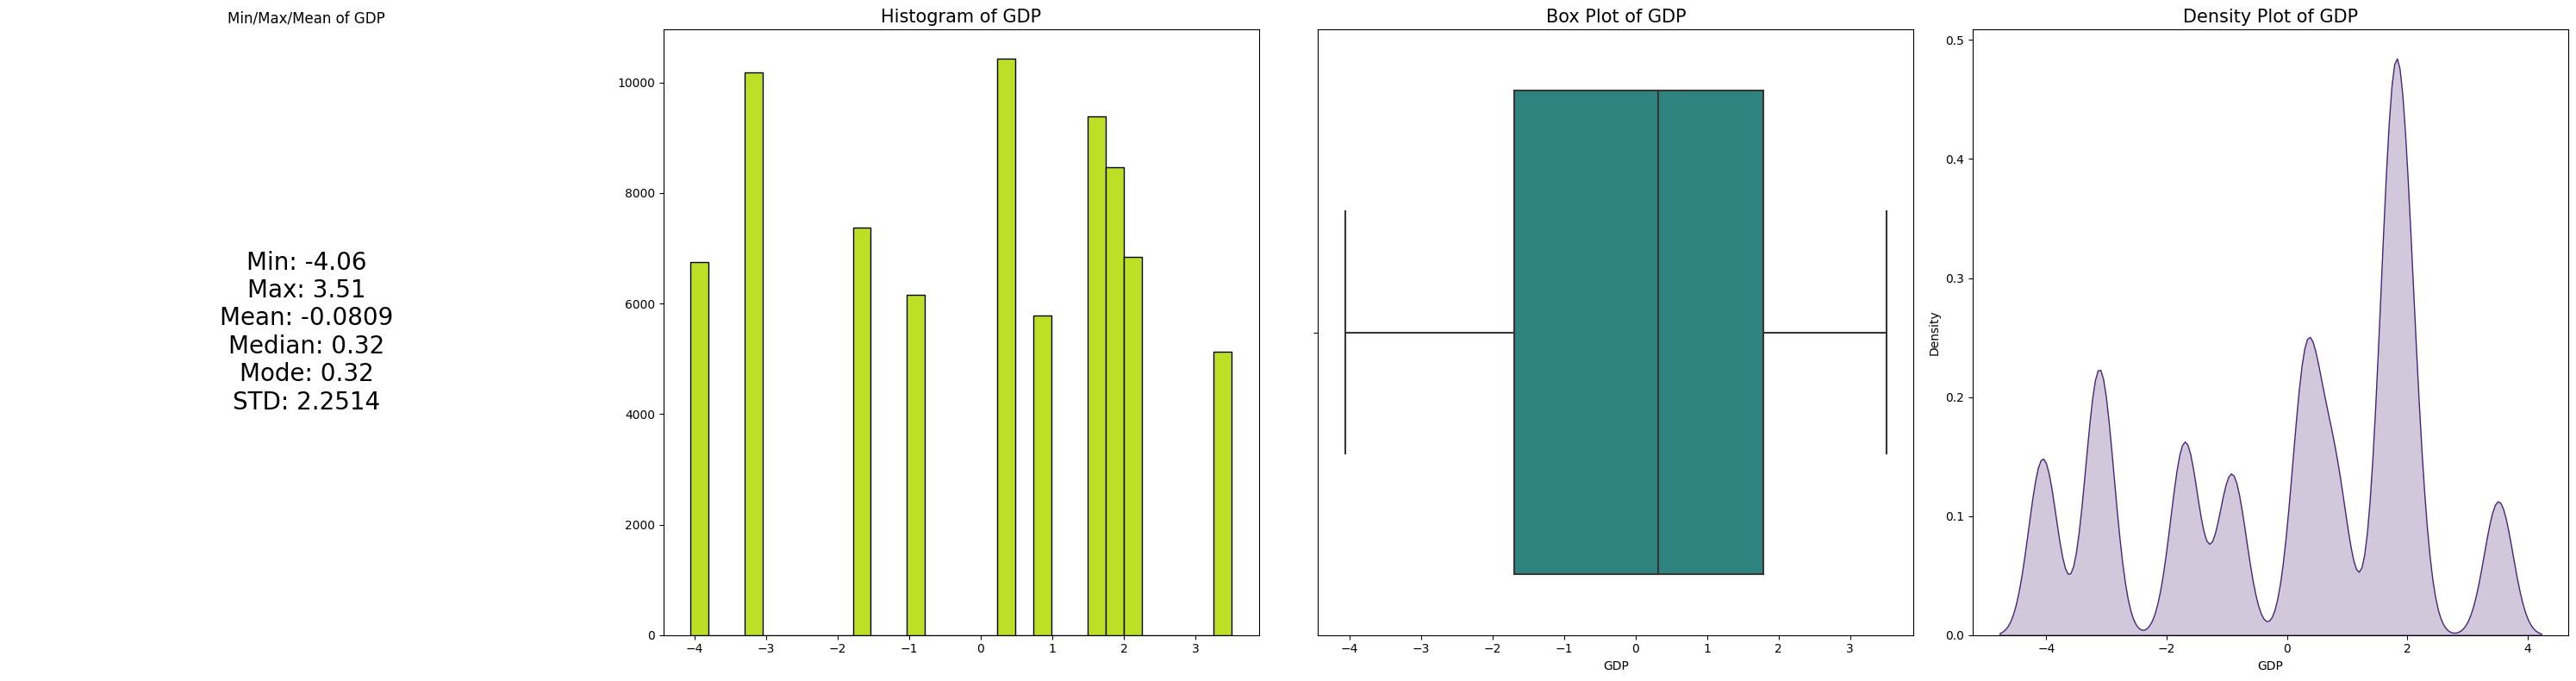

In [8]:
def visualize_columns(df, columns):
    """
    Visualizes the minimum, maximum, histogram, box plot, and density plot for specified columns,
    each in a single row.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    columns (list of str): List of column names to visualize.
    """
    for column in columns:
        if column in df.columns:
            # Create a figure with 1 row and 4 columns of subplots
            fig, axs = plt.subplots(1, 4, figsize=(30, 8))  

            # Min and Max visualization
            min_val = df[column].min()
            max_val = df[column].max()
            mean_val = df[column].mean().round(4)
            median_val = df[column].median()
            mode_val = df[column].mode()[0]
            std_val = round(df[column].std(), 4)
            axs[0].text(0.5, 0.5, f'Min: {min_val}\nMax: {max_val}\nMean: {mean_val}\nMedian: {median_val}\nMode: {mode_val}\nSTD: {std_val}', horizontalalignment='center', 
                        verticalalignment='center', fontsize=20, transform=axs[0].transAxes)
            axs[0].set_title(f'Min/Max/Mean of {column}', fontsize=15)
            axs[0].axis('off')  # Hide axes

            # Histogram
            axs[1].hist(df[column], bins=30, color=plt.cm.viridis(0.9), edgecolor='black')
            axs[1].set_title(f'Histogram of {column}', fontsize=15)

            # Box plot
            sns.boxplot(x=df[column], ax=axs[2], palette='viridis')
            axs[0].set_title(f'Min/Max/Mean of {column}')
            axs[2].set_title(f'Box Plot of {column}', fontsize=15)

            # Density Plot
            sns.kdeplot(df[column], ax=axs[3], fill=True, color=plt.cm.viridis(0.1))
            axs[3].set_title(f'Density Plot of {column}', fontsize=15)

            plt.tight_layout()
            plt.show()
        else:
            print(f"Column '{column}' not found in DataFrame.")


visualize_columns(df_train, df_train.select_dtypes(include=['float64', 'int64']).columns)

Exploring the relationship between categorical variables and target values:

Let’s implement a Chi-Square test of independence as an example to check the association between each categorical feature and the target.

In [9]:
# Define features and labels
X = df_train.drop(columns='Target')
y = df_train['Target']

# Define categorical and numerical features
categorical_features= X.select_dtypes(include='category').columns
numerical_features= X.select_dtypes(include=['float64','int64']).columns

# Find p-values
p_values = {}

for col in categorical_features:
    contingency_table = pd.crosstab(df_train[col], y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values[col] = p

for col, p in p_values.items():
    print(f"P-value for {col} and target: {p}")

P-value for Marital status and target: 0.0
P-value for Application mode and target: 0.0
P-value for Course and target: 0.0
P-value for Daytime/evening attendance and target: 7.26910032868006e-285
P-value for Previous qualification and target: 0.0
P-value for Nacionality and target: 1.6170407486823142e-06
P-value for Mother's qualification and target: 0.0
P-value for Father's qualification and target: 0.0
P-value for Mother's occupation and target: 0.0
P-value for Father's occupation and target: 0.0
P-value for Displaced and target: 0.0
P-value for Educational special needs and target: 0.8900215041644881
P-value for Debtor and target: 0.0
P-value for Tuition fees up to date and target: 0.0
P-value for Gender and target: 0.0
P-value for Scholarship holder and target: 0.0
P-value for International and target: 0.7257456838845804


Interpretation:

Null hypothesis: There is no association between the two variables.

Low p-values (<0.05): Strong evidence against the null hypothesis, suggesting a significant association between the feature and the target. High p-values: Weak evidence against the null hypothesis, no significant association found.

So the features with less than 0.05 p-value have a statistically significant association with the target values. This means that these features likely provide some information about the target categories.

Features with Low p-values (significant association):

Marital Status
Application Mode
Course
Daytime/Evening Attendance (though this is not zero, it's a very small number, indicating significance)
Previous Qualification
Nationality
Mother's Qualification
Father's Qualification
Mother's Occupation
Father's Occupation
Displaced
Debtor
Tuition Fees Up to Date
Gender
Scholarship Holder
Features with High p-values (no significant association):

Educational Special Needs (p-value: 0.8900215041644881)
International (p-value: 0.7257456838845804)
Lets calculate Cramér's V, which measures the strength of association between two categorical variables, we'll use the Chi-Square statistic derived from the contingency table of each feature with the target. Cramér's V provides a value between 0 and 1, where 0 indicates no association and 1 indicates a perfect associationtion.

In [10]:
# Calculate Cramér's V values between each categorical feature and target
def cramers_v(chi2, n, k, r):
    return np.sqrt(chi2 / n / min(k - 1, r - 1))

# Dictionary to store Cramér's V values
cramers_v_results = {}
for col in categorical_features:
    table = pd.crosstab(df_train[col], y)
    chi2, p, dof, expected = chi2_contingency(table)
    n = table.sum().sum()  # Total observations
    r, k = table.shape
    v = cramers_v(chi2, n, k, r)
    cramers_v_results[col] = v

# Print Cramér's V results
for feature, v in cramers_v_results.items():
    print(f"Cramér's V for {feature} and target: {v}")

Cramér's V for Marital status and target: 0.10628042919764649
Cramér's V for Application mode and target: 0.2925086033348213
Cramér's V for Course and target: 0.3363563229904158
Cramér's V for Daytime/evening attendance and target: 0.13076938872211355
Cramér's V for Previous qualification and target: 0.19163279065785732
Cramér's V for Nacionality and target: 0.02382899823451088
Cramér's V for Mother's qualification and target: 0.17652216711285468
Cramér's V for Father's qualification and target: 0.1709744918559326
Cramér's V for Mother's occupation and target: 0.17145722080805317
Cramér's V for Father's occupation and target: 0.16361367741981186
Cramér's V for Displaced and target: 0.1507526910709927
Cramér's V for Educational special needs and target: 0.0017450752140484775
Cramér's V for Debtor and target: 0.25890023084453506
Cramér's V for Tuition fees up to date and target: 0.44717716798875057
Cramér's V for Gender and target: 0.3301968478129784
Cramér's V for Scholarship holder and

Interpretation:

High Association:

Tuition Fees Up to Date: 0.4472 - This feature has the highest association among the features listed, making it a strong predictor.
Scholarship Holder: 0.4064 - Also shows a strong association, suggesting it significantly influences or relates to the target.
Course: 0.3364 - This is another strong indicator, reflecting its relevance to the target.
Gender: 0.3302 - Significant association, useful for predicting the target.
Moderate Association:

Application Mode: 0.2925 - Shows a moderate relationship with the target.
Debtor: 0.2589 - Relatively moderate, indicating some predictive power.
Previous Qualification: 0.1916 - Offers some insight but not as strong as the top predictors.
Mother's Qualification, Mother's Occupation, Father's Qualification, Father's Occupation: These features show similar moderate associations (ranging from 0.1636 to 0.1765), suggesting they hold some predictive value.
Displaced: 0.1508 - Shows a moderate level of association, providing some predictive value.
Daytime/Evening Attendance: 0.1308 - Indicates a moderate association, useful for prediction.
Low Association:

Marital Status: 0.1063 - Low association, but still provides some information about the target.
Nacionality: 0.0238 - Very low association, providing minimal predictive value.
Educational Special Needs: 0.0017 - Very weak or no association, indicating it does not provide significant information about the target.
International: 0.0029 - Very weak or no association, suggesting it has minimal influence on the target.
Consideration

Focus on features with moderate to high Cramér's V values for model building, as these are likely to provide the most predictive power. Consider disregarding or deprioritizing features with very low Cramér's V values in predictive modeling, as they may not contribute significantly to model accuracy. Further investigate combinations of features or interactions that could enhance model performance, especially where moderate associations exist.iations exist.

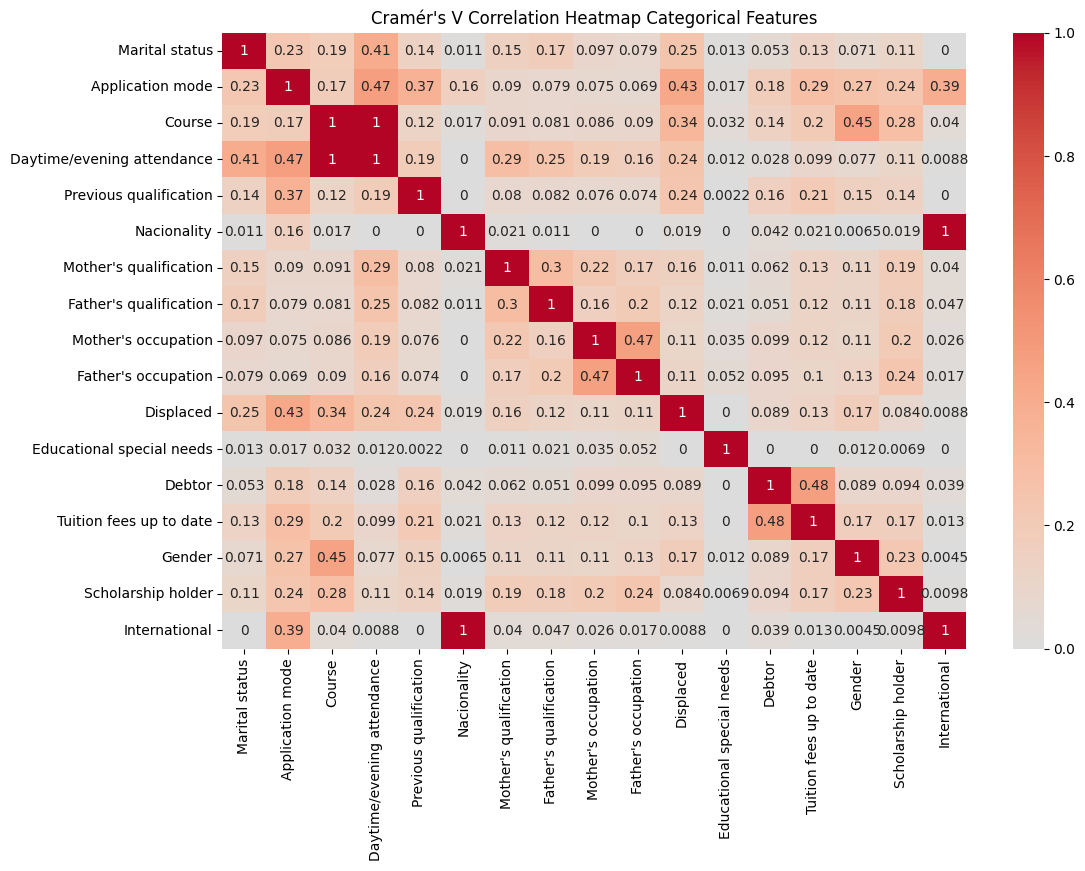

In [11]:
# Calculate Cramér's V statistic between each 2 categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df_train[col1], df_train[col2])

# Convert the matrix to numeric for heatmap plotting
cramers_v_matrix = cramers_v_matrix.astype(float)

# Heatmap of the correlation
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Cramér's V Correlation Heatmap Categorical Features")
plt.show()

Interpretation:

Features highly correlated:

Daytime/evening attendance & course
Nacionality & International

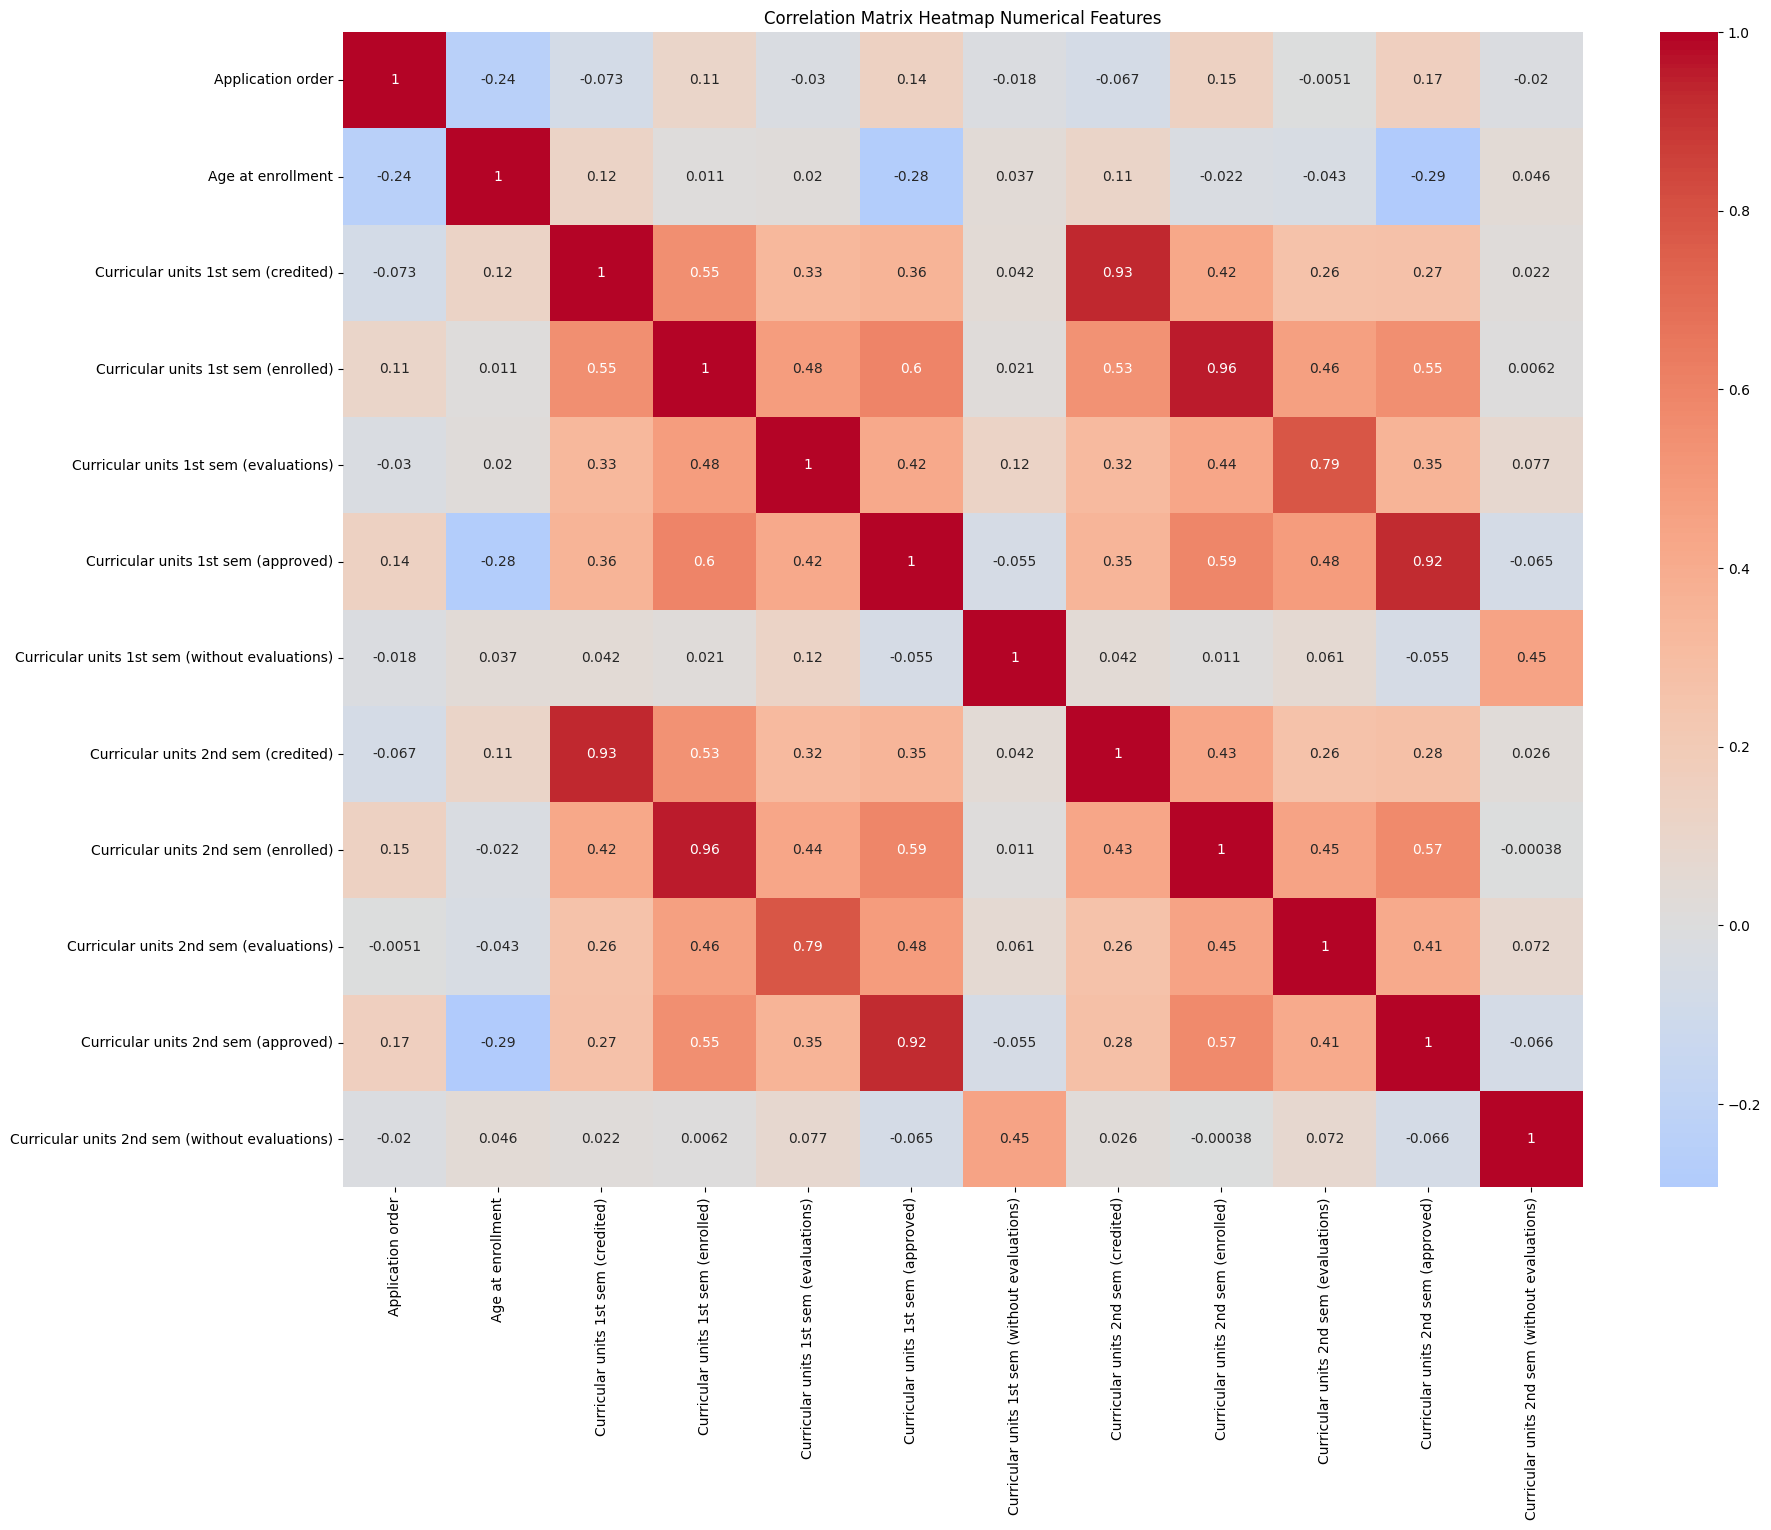

In [12]:
# Heatmap of the correlation matrix
categorical_features= X.select_dtypes(include='category').columns
numerical_features= X.select_dtypes(include=['int64']).columns
correlation_matrix=df_train[numerical_features].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap Numerical Features')
plt.show()

Interpretation:

Features highly correlated:

curricular unites 1st sem (credited) & curricular unites 2st sem (credited)
curricular unites 1st sem (enrolled) & curricular unites 2st sem (enrolled)
curricular unites 1st sem (approved) & curricular unites 2st sem (approved)
Correlation Ratio (Eta squared):

Measures the strength of the association between a numerical feature and a categorical target. It is similar to the concept of correlation but adapted for numerical-categorical relationships.

In [13]:
# Define the eta_squared function
def eta_squared(x, y):
    categories = np.unique(y)
    overall_mean = np.mean(x)
    ssw = np.sum([np.sum((x[y == category] - np.mean(x[y == category])) ** 2) for category in categories])
    sst = np.sum((x - overall_mean) ** 2)
    return 1 - ssw / sst

# Calculate Correlation Ratio (Eta squared)
eta2_results = {}
for feature in numerical_features:
    eta2 = eta_squared(df_train[feature], df_train['Target'])
    eta2_results[feature] = eta2
    print(f"Correlation Ratio (Eta squared) for {feature} and Target: {eta2}")

Correlation Ratio (Eta squared) for Application order and Target: 0.018207814674233824
Correlation Ratio (Eta squared) for Age at enrollment and Target: 0.11183470295840992
Correlation Ratio (Eta squared) for Curricular units 1st sem (credited) and Target: 0.0014683726620997595
Correlation Ratio (Eta squared) for Curricular units 1st sem (enrolled) and Target: 0.07020372984448042
Correlation Ratio (Eta squared) for Curricular units 1st sem (evaluations) and Target: 0.0857787771565297
Correlation Ratio (Eta squared) for Curricular units 1st sem (approved) and Target: 0.5316473743062946
Correlation Ratio (Eta squared) for Curricular units 1st sem (without evaluations) and Target: 0.004069085051856325
Correlation Ratio (Eta squared) for Curricular units 2nd sem (credited) and Target: 0.0017010374948668305
Correlation Ratio (Eta squared) for Curricular units 2nd sem (enrolled) and Target: 0.08502198363117652
Correlation Ratio (Eta squared) for Curricular units 2nd sem (evaluations) and Tar

Interpretation: Very Weak or No Association (0.0 to 0.1)

Application order: 0.0182
Previous qualification (grade): 0.0263
Admission grade: 0.0318
Curricular units 1st sem (credited): 0.0015
Curricular units 1st sem (without evaluations): 0.0041
Curricular units 2nd sem (credited): 0.0017
Curricular units 2nd sem (without evaluations): 0.0061
Unemployment rate: 0.0037
Inflation rate: 0.0037
GDP: 0.0108
Weak Association (0.1 to 0.3)

Age at enrollment: 0.1118
Curricular units 1st sem (enrolled): 0.0702
Curricular units 1st sem (evaluations): 0.0858
Curricular units 2nd sem (enrolled): 0.0850
Curricular units 2nd sem (evaluations): 0.1285
Moderate Association (0.3 to 0.5)

Curricular units 1st sem (grade): 0.4679
Strong Association (0.5 to 1.0)

Curricular units 1st sem (approved): 0.5316
Curricular units 2nd sem (approved): 0.6134
Curricular units 2nd sem (grade): 0.5580

# ⚙ Feature Engineering

Application order

This feature ranging from 0 (first choice) to 9 (last choice), offers useful insights into the preferences or priorities associated with each application. Given the distribution and characteristics of application order, we can see that the majority of our applicants are in top three choices in our dataset. Only 3 people were first choice and only one person was the last choice. Question is what can we do with this, so that we can improve the predictive power of our model?

Solution:

Binning:
Transform the application order into categorical bins. For example, grouping orders into 'Top Choice' (0-1), 'Middle Choice' (2-5), and 'Lower Choice' (6-9). This can simplify the model’s understanding of preference tiers.

Rank Transformation:
Convert the application order into a rank percentage (i.e., normalized rank from 0 to 1). This can help in stabilizing the learning across different scales, particularly if combined with other numerical features.

Remove Extreme Outlier:
We can also get rid of application order 9, since there is not much data on that, it can be considered as outlier.

Later on we can check which one works best with our model. For the purpose of this submission (Week 2), I did not incorporate Rank Transformation.

In [14]:
#Remove extreme outlier
df_train = df_train[df_train['Application order'] != 9]
# The max value in training data is 8
max_train_value = 8
df_test['Application order'] = df_test['Application order'].apply(lambda x: min(x, max_train_value))

In [15]:
#Binning
bins = [-1, 1, 5, 9]
labels = ['Top Choice', 'Middle Choice', 'Lower Choice']
df_train['Application order'] = pd.cut(df_train['Application order'], bins=bins, labels=labels, include_lowest=True).astype('category')
df_test['Application order'] = pd.cut(df_test['Application order'], bins=bins, labels=labels, include_lowest=True).astype('category')

In [16]:
df_train = pd.get_dummies(df_train, columns=['Application order'], dummy_na=False, drop_first=False)
df_test = pd.get_dummies(df_test, columns=['Application order'], dummy_na=False, drop_first=False)

In [17]:
# Set the display option to show all columns
pd.set_option('display.max_columns', None)
df_train.head()

,Marital status,Application mode,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Application order_Top Choice,Application order_Middle Choice,Application order_Lower Choice
0,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate,True,False,False
1,1,17,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout,True,False,False
2,1,17,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout,False,True,False
3,1,1,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled,False,True,False
4,1,1,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate,False,True,False


In [18]:
# Convert Boolean columns to integer
for col in df_train.columns:
    if df_train[col].dtype == 'bool':
        df_train[col] = df_train[col].astype(int)

for col in df_test.columns:
    if df_test[col].dtype == 'bool':
        df_test[col] = df_test[col].astype(int)

**curricular units 1st sem (credited)**

The majority of data points (students) are at zero for this feature. I created a binary feature indicating whether a student has been credited for any units in first semester or not. This seems more helpful for our modeling purpose.

In [19]:
df_train['Credited_units_1st_sem'] = (df_train['Curricular units 1st sem (credited)'] > 0).astype(int)
df_test['Credited_units_1st_sem'] = (df_test['Curricular units 1st sem (credited)'] > 0).astype(int)

In [20]:
df_train['Credited_units_1st_sem'].value_counts()

Credited_units_1st_sem
0    73428
1     3089
Name: count, dtype: int64

In [21]:
# Drop the column 'curricular units 1st sem (credited)' from the DataFrame
df_train.drop('Curricular units 1st sem (credited)', axis=1, inplace=True)
df_test.drop('Curricular units 1st sem (credited)', axis=1, inplace=True)

**curricular units 2nd sem (credited)**

The majority of data points (students) are at zero for this feature. I created a binary feature indicating whether a student has been credited for any units in first semester or not. This seems more helpful for our modeling purpose.

In [22]:
df_train['Curricular units 2nd sem (credited)'] = (df_train['Curricular units 2nd sem (credited)'] > 0).astype(int)
df_test['Curricular units 2nd sem (credited)'] = (df_test['Curricular units 2nd sem (credited)'] > 0).astype(int)

In [23]:
df_train['Curricular units 2nd sem (credited)'].value_counts()

Curricular units 2nd sem (credited)
0    73808
1     2709
Name: count, dtype: int64

In [24]:
# Drop the column 'curricular units 1st sem (credited)' from the DataFrame
df_train.drop('Curricular units 2nd sem (credited)', axis=1, inplace=True)
df_test.drop('Curricular units 2nd sem (credited)', axis=1, inplace=True)

Age at enrollment( based on knowledge base )

To effectively analyze and utilize the age at enrollment data for predicting outcomes such as graduation, dropout, or continued enrollment, we consider the typical duration of a bachelor's program, which is generally 3 to 4 years. Based on this, it makes sense to categorize the ages into groups spanning four years each. This approach allows us to capture the typical time frame a student spends in undergraduate studies and align our analysis with meaningful age cohorts that may exhibit similar educational behaviors or outcomes. Therefore, I have structured the age data into bins of four-year ranges, starting from the minimum age of 18, to facilitate a more targeted and relevant analysis of our dataset.

In [25]:
bins = [17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73]
labels = ['18-21', '22-25', '26-29', '30-33', '34-37', '38-41', '42-45', '46-49', '50-53', '54-57', '58-61', '62-65', '66-69', '70-73']

# Bin the age data
df_train['Age at enrollment'] = pd.cut(df_train['Age at enrollment'], bins=bins, labels=labels, right=True).astype('category')
df_train = pd.get_dummies(df_train, columns=['Age at enrollment'], dummy_na=False, drop_first=False)

df_test['Age at enrollment'] = pd.cut(df_test['Age at enrollment'], bins=bins, labels=labels, right=True).astype('category')
df_test = pd.get_dummies(df_test, columns=['Age at enrollment'], dummy_na=False, drop_first=False)

# Convert Boolean columns to integer
for col in df_train.columns:
    if df_train[col].dtype == 'bool':
        df_train[col] = df_train[col].astype(int)
for col in df_test.columns:
    if df_test[col].dtype == 'bool':
        df_test[col] = df_test[col].astype(int)

In [26]:
df_train.head()

,Marital status,Application mode,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Application order_Top Choice,Application order_Middle Choice,Application order_Lower Choice,Credited_units_1st_sem,Age at enrollment_18-21,Age at enrollment_22-25,Age at enrollment_26-29,Age at enrollment_30-33,Age at enrollment_34-37,Age at enrollment_38-41,Age at enrollment_42-45,Age at enrollment_46-49,Age at enrollment_50-53,Age at enrollment_54-57,Age at enrollment_58-61,Age at enrollment_62-65,Age at enrollment_66-69,Age at enrollment_70-73
0,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,0,6,6,6,14.500000,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,17,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,0,6,8,4,11.600000,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,17,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,0,6,0,0,0.000000,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,0,7,9,7,12.591250,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,0,7,12,6,12.933333,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
print(df_train.dtypes)


Marital status                                    category
Application mode                                  category
Course                                            category
Daytime/evening attendance                        category
Previous qualification                            category
Previous qualification (grade)                     float64
Nacionality                                       category
Mother's qualification                            category
Father's qualification                            category
Mother's occupation                               category
Father's occupation                               category
Admission grade                                    float64
Displaced                                         category
Educational special needs                         category
Debtor                                            category
Tuition fees up to date                           category
Gender                                            catego

Age at enrollment (Custom Binning Based on Distribution):

We created bins based on the observed distribution in boxplot as well. Since the majority of the ages fall between 17 and 40, we create more bins in this range and fewer bins for older ages.

In [28]:
columns_to_drop_based_p_value = ['Educational Special Needs', 'International']  # Based on p_value
columns_to_drop_based_cramersV = ['Marital Status', 'International', 'Nacionality', 'Educational Special Needs']  # Based on p_value
columns_to_drop_based_heatmaps = [
    'Daytime/evening attendance',
    'Nacionality', 'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (approved)'
    ]
columns_to_drop_based_eta = [
    'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP'
    ]

columns_to_drop = columns_to_drop_based_p_value + columns_to_drop_based_cramersV + columns_to_drop_based_heatmaps + columns_to_drop_based_eta

# Drop the columns
df_train_drop= df_train.drop( columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)
df_test_drop= df_test.drop( columns=[col for col in columns_to_drop if col in df_test.columns], inplace=True )

In [29]:
# Define new features based on existing features
# For training data
# Calculate the difference between grades in the 1st and 2nd semesters
df_train['sem_diff_grade'] = df_train['Curricular units 1st sem (grade)'] - df_train['Curricular units 2nd sem (grade)']

# Calculate the difference between enrolled and approved units in the 2nd semester
df_train['sem_diff_enrolled_approved_2nd'] = df_train['Curricular units 2nd sem (enrolled)'] - df_train['Curricular units 2nd sem (approved)']

# Calculate the difference between approved units and evaluations in the 2nd semester
df_train['sem_diff_approved_evaluations_2nd'] = df_train['Curricular units 2nd sem (approved)'] - df_train['Curricular units 2nd sem (evaluations)']

# Drop the original columns that were used to create the new features
df_train.drop(columns=['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)'], inplace=True)
df_train.drop(columns=['Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (evaluations)'], inplace=True)

# For test data (similar operations as for training data)
df_test['sem_diff_grade'] = df_test['Curricular units 1st sem (grade)'] - df_test['Curricular units 2nd sem (grade)']
df_test['sem_diff_enrolled_approved_2nd'] = df_test['Curricular units 2nd sem (enrolled)'] - df_test['Curricular units 2nd sem (approved)']
df_test['sem_diff_approved_evaluations_2nd'] = df_test['Curricular units 2nd sem (approved)'] - df_test['Curricular units 2nd sem (evaluations)']

# Drop the original columns that were used to create the new features
df_test.drop(columns=['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)'], inplace=True)
df_test.drop(columns=['Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (evaluations)'], inplace=True)


In [30]:
# Define features and labels
X = df_train.drop(columns='Target')
y = df_train['Target']

# Modeling + Submission

In [31]:
# Modeling 
# cat_features=categorical_features.tolist()
cat_columns = X.select_dtypes(include='category').columns.tolist()

# From our previous notebook: the best hyperparameters found using Optuna
best_params = {'learning_rate': 0.12146914273449388, 'iterations': 2656, 'depth': 3, 'l2_leaf_reg': 0.8104011685674616, 
                  'border_count': 298, 'random_strength': 0.9482384798609886, 'bagging_temperature': 0.0814623508183759}   

model = CatBoostClassifier(**best_params, cat_features=cat_columns, verbose=0)

# Make predictions on the test dataset
model.fit(X, y)
predictions = model.predict(df_test)

# Reshape predictions array to be 1-dimensional
predictions_flat = predictions.flatten()

# Prepare the submission dataframe
submission = pd.DataFrame({
    'id': submission_id,
    'Target': predictions_flat
})

print('Submission head:', submission.head(10))

# Save the submission dataframe to a CSV file
submission.to_csv('submission.csv', index=False)


Submission head:       id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Enrolled
4  76522  Enrolled
5  76523  Graduate
6  76524  Graduate
7  76525  Graduate
8  76526   Dropout
9  76527  Graduate
